In [94]:
setwd("/Users/micaelawiseman/PhD/Thesis/Winterlight")
source("/Users/micaelawiseman/PhD/Thesis/Winterlight/Code/WL_helperfuncs.r", encoding = "UTF-8")

Load and clean data

In [95]:
# Read and preprocess speech datasets
library(readxl)
library(dplyr)
library(readr)
library(tidyr)

# Read datasets
# Read and preprocess speech data
WL <- speech_read_and_preprocess("~/PhD/Thesis/Data/WINTERLIGHT_Sunnybrook_rTMS_2023_11_03.csv")
WL_2 <- speech_read_and_preprocess("~/PhD/Thesis/Data/WINTERLIGHT_Sunnybrook_rTMSremote_2023_11_03.csv")

# Apply filters
WL <- WL[grep("^(TMS|MDD)", WL$participant_external_id), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039" & WL_2$session_label %in% c("V2", "V3", "V4")), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039b" & WL_2$session_label == "V1"), ]
WL_2$participant_external_id[WL_2$session_label %in% c("V2", "V3") & WL_2$participant_external_id == "TMS039b"] <- "TMS039"

# Combine datasets
WL_combined <- rbind(WL, WL_2)

# Processing participant_group
WL_combined$participant_group <- factor(
  ifelse(
    grepl("(^CTC|C_CTC)", WL_combined$participant_external_id), "Control",
    ifelse(grepl("^(TMS|MDD)", WL_combined$participant_external_id), "MDD", NA)
  )
)

# Exclude specific participants
WL_combined <- WL_combined[WL_combined$participant_external_id != "CTC036" &
                          WL_combined$participant_external_id != "CTC004" &
                          WL_combined$participant_external_id != "CTC006" &
                          WL_combined$participant_external_id != "CTC017" &
                          WL_combined$participant_external_id != "CTC030" &
                          WL_combined$participant_external_id != "CTC039" &
                          WL_combined$participant_external_id != "CTC043" &
                          WL_combined$participant_external_id != "CTC045" &
                          WL_combined$participant_external_id != "CTC053" &
                          WL_combined$participant_external_id != "CTC052" &
                          WL_combined$participant_external_id != "CTC058" &
                          WL_combined$participant_external_id != "CTC058_new" &
                          WL_combined$participant_external_id != "CTC023" &
                          WL_combined$participant_external_id != "CTB001", ]

# Define remote participants and assign testing location
remote_participants <- c("CTC001", "CTC015", "CTC021", "CTC028", "CTC013", "CTC030", 
                         "CTC034", "CTC036", "CTC045", "TMS038", "TMS040", "TMS041", "TMS042")
WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% remote_participants, 
                                       "remote", "in-person")

# Replace values in session_label column
WL_combined$session_label <- gsub("Baseline", "V1", WL_combined$session_label)

# Read and process demographic data
demoMDD <- demo_read_and_process(1)
demoCTRL <- demo_read_and_process(2)

# Generate new column names
column_mapping <- setNames(
    # Old names
  c(paste0(rep(c("bl_", "2wk_", "4wk_"), each = 1), "qids_tot"),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 16), "qids_sr_", 1:16),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_", 1:8),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_tot")),
  # New names
  c(paste0("qids_total_", c("pre", "wk2", "wk4")),
    paste0("qids_", 1:16, "_", rep(c("pre", "wk2", "wk4"), each = 16)),
    paste0("gad7_", 1:8, "_", rep(c("pre", "wk2", "wk4"), each = 8)),
    paste0("gad7_total_", rep(c("pre", "wk2", "wk4"), each = 8)))
)

# Remove leading and trailing whitespaces from column names in demoCTRL
demoCTRL <- demoCTRL %>%
  rename_all(~trimws(.))

# Rename columns in demoCTRL
demoCTRL <- demoCTRL %>% rename(!!!column_mapping)

# Combine demographic datasets
demoMDD$dob_yr <- as.numeric(demoMDD$dob_yr)
demoCTRL$dob_yr <- as.numeric(demoCTRL$dob_yr)
demoALL <- bind_rows(demoMDD, demoCTRL)

# Merge relevant columns from demoALL into WL

WL_demo <- WL_combined %>% left_join(demoALL %>% select(participant_external_id, sex,
                                          age_screening,
                                          years_education,
                                          age_learned_english,
                                          first_language_english,
                                          starts_with("qids"),
                                          starts_with("gad7")))

# Read in psychiatry data
psych <- read_csv("~/PhD/Thesis/Data/Final_Consolidated_Psychiatry_Data.csv")

# Filter to match participant IDs in WL_demo
psych_filtered <- psych %>%
  filter(participant_external_id %in% WL_demo$participant_external_id)

# Merge the datasets based on "participant_external_id" and retain all columns
# Use full_join to include all participants from both datasets
WL_demo_psych <- full_join(psych_filtered %>% select(participant_external_id,
                                              starts_with("hamd17"),
                                              starts_with("qids"),
                                              starts_with("gad7")),
                           WL_demo,
                           by = "participant_external_id",
                           suffix = c("", ".psych"))

# Identify common columns (excluding "participant_external_id")
common_columns <- setdiff(intersect(names(WL_demo), names(psych_filtered)), "participant_external_id")

# Update NA values in WL_demo columns with values from psych where applicable
WL_demo_psych <- WL_demo_psych %>%
  mutate(across(all_of(common_columns), 
  ~ifelse(is.na(.), get(paste0(cur_column(), ".psych")), .)))

# Optionally, remove the extra columns if they are no longer needed
WL_demo_psych <- select(WL_demo_psych, -ends_with(".psych"))

# Check the structure of the final dataframe
str(WL_demo_psych)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Joining with `by = join_by(participant_external_id)`
Rows: 52 Columns: 976
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (71): participant_external_id, demographic_data_timestamp, demog_househ...
dbl (785): demog_gender, demog_sex, demog_age, demog_married, demog_children...
lgl (120): demog_gender_other, demog_sex_other, pretreatment_clinician_admin...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [951 x 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:951] "TMS001" "TMS001" "TMS001" "TMS001" ...
 $ hamd17_1_pre                                               : num [1:951] 4 4 4 4 4 4 4 4 4 4 ...
 $ hamd17_2_pre                                               : num [1:951] 2 2 2 2 2 2 2 2 2 2 ...
 $ hamd17_3_pre                                               : num [1:951] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_4_pre                                               : num [1:951] 2 2 2 2 2 2 2 2 2 2 ...
 $ hamd17_5_pre                                               : num [1:951] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_6_pre                                               : num [1:951] 0 0 0 0 0 0 0 0 0 0 ...
 $ hamd17_7_pre                                               : num [1:951] 3 3 3 3 3 3 3 3 3 3 ...
 $ hamd17_8_pre                                               : num [1:951] 1 1 1 1 1 1 1 1 1 1 ...
 $ hamd17_9_pre                    

Subset by task (journalling) and visit (baseline)

In [96]:
# Subset to look at journaling and baseline scores
WL_full_jou <-subset_by_task(WL_demo_psych, "journaling")
WL_full_jou_bl<-subset_by_visit(WL_full_jou, "V1")

str(WL_full_jou_bl)

tibble [132 x 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:132] "TMS001" "TMS001" "TMS002" "TMS002" ...
 $ hamd17_1_pre                                               : num [1:132] 4 4 3 3 3 3 3 3 4 4 ...
 $ hamd17_2_pre                                               : num [1:132] 2 2 0 0 1 1 3 3 2 2 ...
 $ hamd17_3_pre                                               : num [1:132] 0 0 4 4 2 2 2 2 2 2 ...
 $ hamd17_4_pre                                               : num [1:132] 2 2 1 1 1 1 0 0 2 2 ...
 $ hamd17_5_pre                                               : num [1:132] 0 0 0 0 1 1 2 2 0 0 ...
 $ hamd17_6_pre                                               : num [1:132] 0 0 2 2 2 2 2 2 0 0 ...
 $ hamd17_7_pre                                               : num [1:132] 3 3 3 3 4 4 3 3 3 3 ...
 $ hamd17_8_pre                                               : num [1:132] 1 1 0 0 1 1 0 0 1 1 ...
 $ hamd17_9_pre                    

Narrow down target demographic and speech variables and check missing 

In [97]:
# Categorizing variables into Clinical, Demographic, and Speech variables
demographic_variables <- c('sex', 'age_screening', 'participant_group', 'age_learned_english', 'testing_location','years_education',"first_language_english")
speech_variables <- c('fundamental_frequency_mean','fundamental_frequency_variance', 'intensity_mean_db','medium_pause_duration',
                    'speech_rate', 'sentiment_dominance', 'sentiment_valence',
                    'sentiment_arousal')

# Creating subsets of data based on these categories
clinical_data <- WL_full_jou_bl[, c("participant_external_id", "hamd17_total_pre")]
demographic_data <- WL_full_jou_bl[, c("participant_external_id", demographic_variables)]
speech_data <- WL_full_jou_bl[, c("participant_external_id", speech_variables)]

speech_missing <- analyze_missing_data(speech_data, "participant_external_id")
write.csv(speech_missing, "~/PhD/Thesis/Data/speech_missing.csv")


# For clinical data
clinical_missing <- analyze_missing_data(clinical_data, "participant_external_id")
write.csv(clinical_missing, "~/PhD/Thesis/Data/clinical_missing.csv")


# For demographic data
demographic_missing <- analyze_missing_data(demographic_data, "participant_external_id")
write.csv(demographic_missing, "~/PhD/Thesis/Data/demographic_missing.csv")

Linear models in MDD patients (with interaction term)

In [67]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("lmtest")

library(dplyr)
library(ggplot2)
library(lmtest)

WL_full_jou_bl$sex <- as.factor(WL_full_jou_bl$sex)
WL_full_jou_bl$testing_location <- as.factor(WL_full_jou_bl$testing_location)
WL_jou_bl_MDD <- WL_full_jou_bl %>% filter(participant_group == "MDD")
WL_jou_bl_MDD_feeling <- WL_jou_bl_MDD %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

results <- list()
plots <- list()

# Create a directory for the plots
plots_directory <- "~/PhD/Thesis/Plots/"
if (!dir.exists(plots_directory)) {
    dir.create(plots_directory)
}

for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression with interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "* sex + age_screening + age_learned_english"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre interaction", sep = "_")]] <- model_summary
    
    # Create a plot
    plot_name <- paste(s," hamd17_total_pre interaction_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre", color = "sex")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE, 
                    aes_string(group = "sex", color = "sex")) + 
    labs(title = paste(s, "X", "hamd17_total_pre", sep = " "),
         x = s, y = "hamd17_total_pre") +
    theme_minimal() +
    theme(plot.title = element_text(size = 17)) # smaller title

  # Save the plot
  file_name <- paste(plots_directory, "/", plot_name, ".png", sep = "")
  ggsave(file_name, plot, width = 6, height = 4, bg = "white")
}

print(plots)
print(results)


Linear models in MDD patients without interaction term

In [98]:
library(dplyr)
library(ggplot2)
library(lmtest)

results <- list()
plots <- list()
stats_df <- data.frame()  # Dataframe to store statistics
p_values_lms <- c()  # Vector to collect p-values

# Create a directory for the plots
plots_directory <- "~/PhD/Thesis/Plots/"
if (!dir.exists(plots_directory)) {
    dir.create(plots_directory)
}

for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression without interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "+ sex + age_screening + age_learned_english"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre", sep = "_")]] <- model_summary
    
    # Extract coefficients and p-values
    coefs <- summary(model)$coefficients
    p_values_lms<- c(p_values_lms, coefs[2, "Pr(>|t|)"])  # Collect p-values
    
    # Create a summary stats row
    stats_row <- data.frame(variable = s, 
                            estimate = coefs[2, "Estimate"], 
                            std_error = coefs[2, "Std. Error"], 
                            statistic = coefs[2, "t value"], 
                            p_value = coefs[2, "Pr(>|t|)"])
    stats_df <- rbind(stats_df, stats_row)  # Append to the stats dataframe

    # Create and save plots
    plot_name <- paste(s, "hamd17_total_pre_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE) + 
        labs(title = paste(s, "vs", "hamd17_total_pre"),
             x = s, y = "hamd17_total_pre") +
        theme_minimal() +
        theme(plot.title = element_text(size = 17))
    file_name <- paste(plots_directory, "/", plot_name, ".png", sep = "")
    ggsave(file_name, plot, width = 6, height = 4, bg = "white")
}

# Print and save results
print(plots)
print(results)
write.csv(stats_df, file = paste(plots_directory, "/SOBPS_LMs_summary_statistics.csv", sep = ""))



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


list()
$fundamental_frequency_mean_hamd17_total_pre

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6981 -3.4666 -0.2955  2.0006  9.2654 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)  
(Intercept)                14.118368   5.435181   2.598   0.0139 *
fundamental_frequency_mean  0.041450   0.028551   1.452   0.1560  
sexM                        2.309264   2.031290   1.137   0.2638  
age_screening               0.009367   0.055349   0.169   0.8666  
age_learned_english        -0.036846   0.128866  -0.286   0.7767  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.206 on 33 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.06458,	Adjusted R-squared:  -0.0488 
F-statistic: 0.5696 on 4 and 33 DF,  p-value: 0.6865


$fundamental_frequency_variance_hamd17_total_pre

Call:
lm(formula = formula, data = filtered_data)



Correction for multiple comparisons

In [46]:
adjusted_p_values <- p.adjust(p_values_lms, method = "BH")
# Display the original and adjusted p-values
data.frame(Original_P_Value = p_values_lms, Adjusted_P_Value = adjusted_p_values)

Original_P_Value,Adjusted_P_Value
<dbl>,<dbl>
0.1560039,0.6532403
0.6255178,0.7148775
0.4899302,0.6532403
0.4318237,0.6532403
0.8165480,0.8165480
0.3362275,0.6532403
0.3016326,0.6532403
0.3183920,0.6532403


ANCOVAs by group controlling for sex

                        Variable     F_Value        Pr_F  Df
1     fundamental_frequency_mean 4.830965028 0.032103815 1/1
2 fundamental_frequency_variance 1.540766807 0.219678147 1/1
3              intensity_mean_db 0.002786822 0.958086812 1/1
4          medium_pause_duration 4.238345420 0.044183824 1/1
5                    speech_rate 7.823734245 0.007054921 1/1
6            sentiment_dominance 3.929562985 0.052359142 1/1
7              sentiment_valence 5.369443785 0.024173300 1/1
8              sentiment_arousal 7.890416735 0.006830906 1/1
  Partial_Eta_Squared     Mean_MDD       SD_MDD Mean_Control   SD_Control
1        0.0794162155  136.5045444   36.1569082  173.6192293   35.4671521
2        0.0267769599 3234.3099231 2860.8417301 3163.6266027 2268.2896424
3        0.0000497622   54.9379564    5.1918391   55.2521216    3.1669611
4        0.0703595922    0.4088105    0.2037871    0.3007412    0.1986712
5        0.1225834611   97.8295876   50.5550743  137.6435792   35.8476318
6      

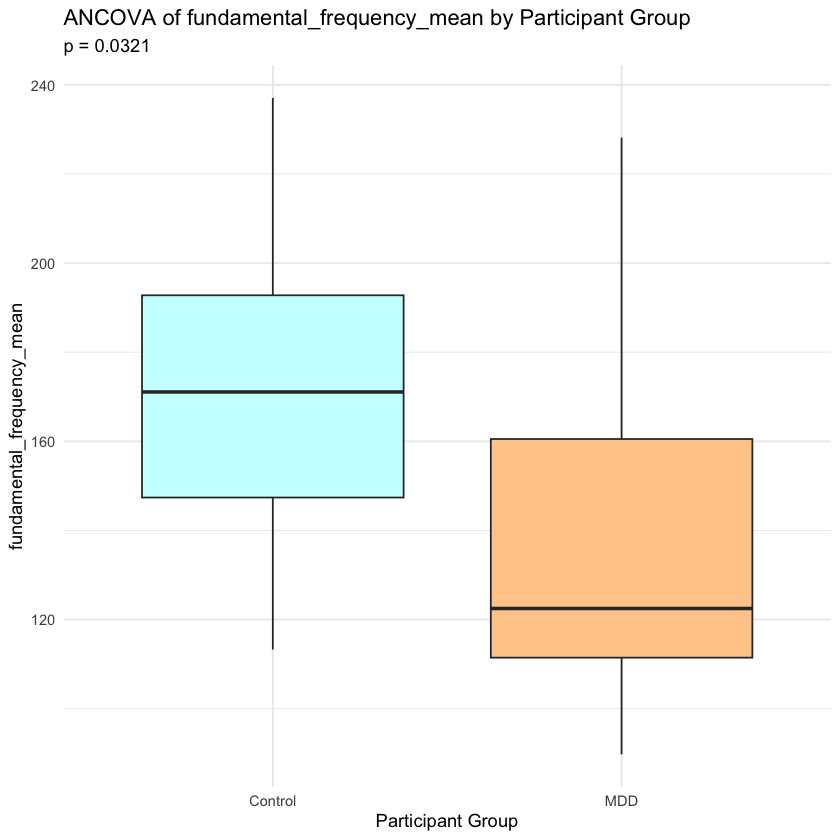

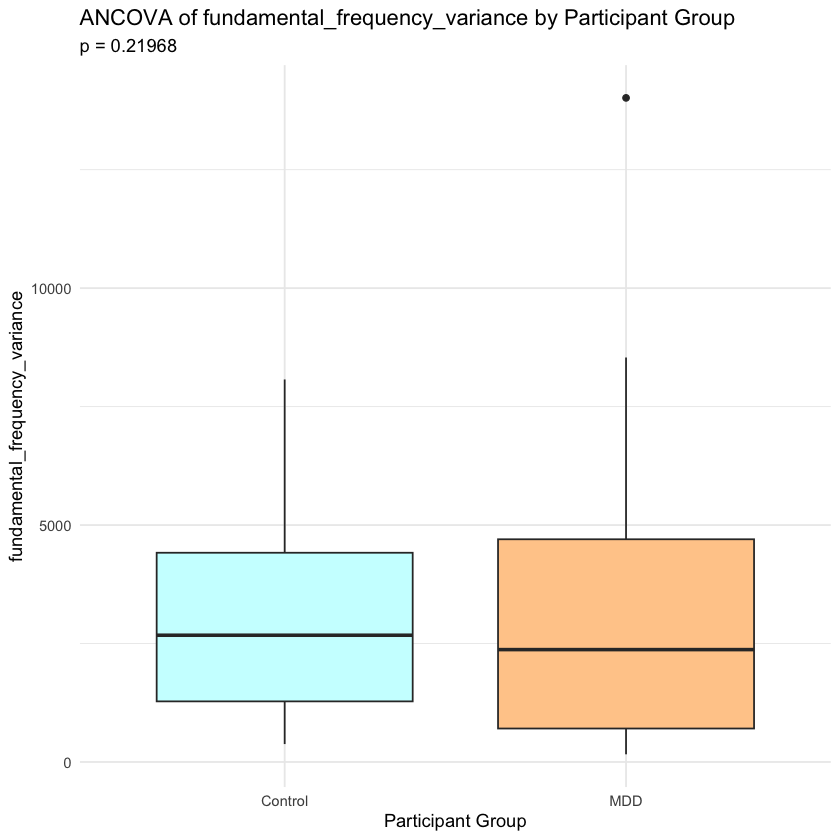

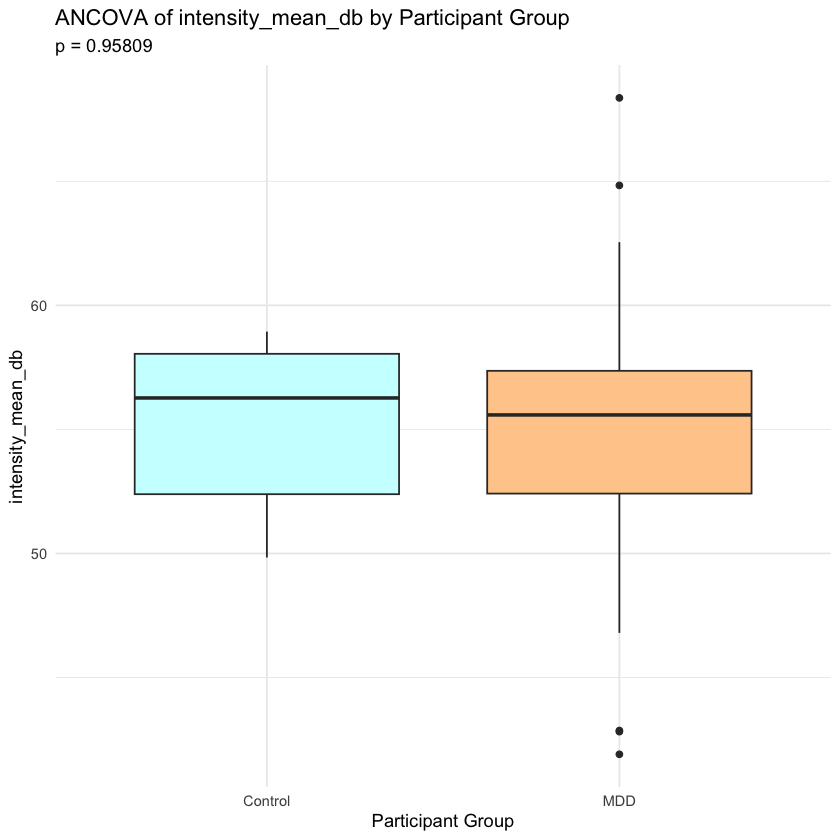

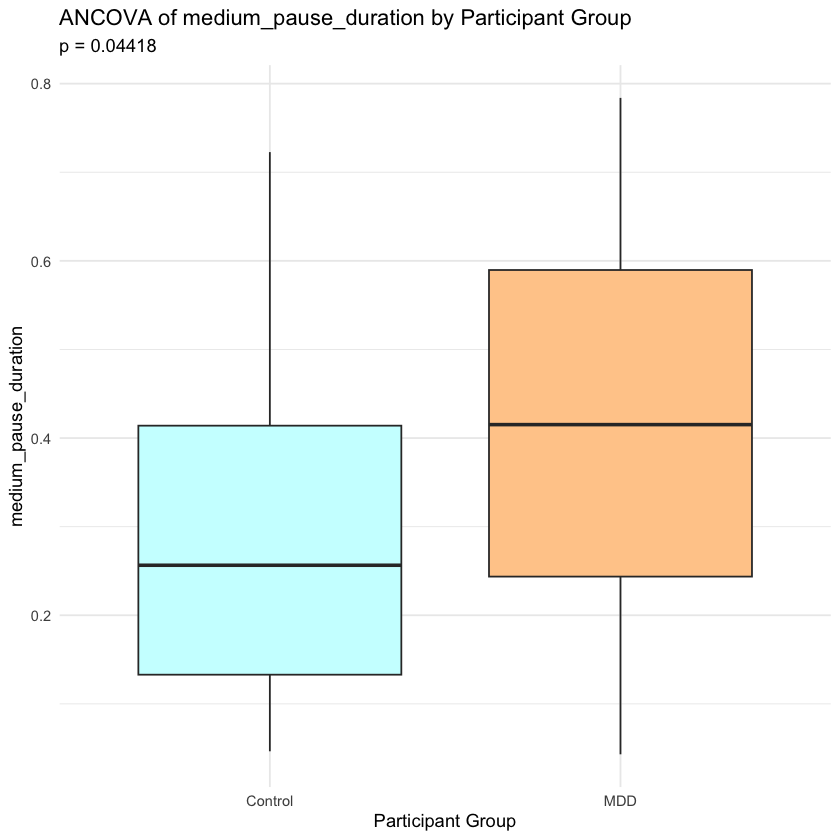

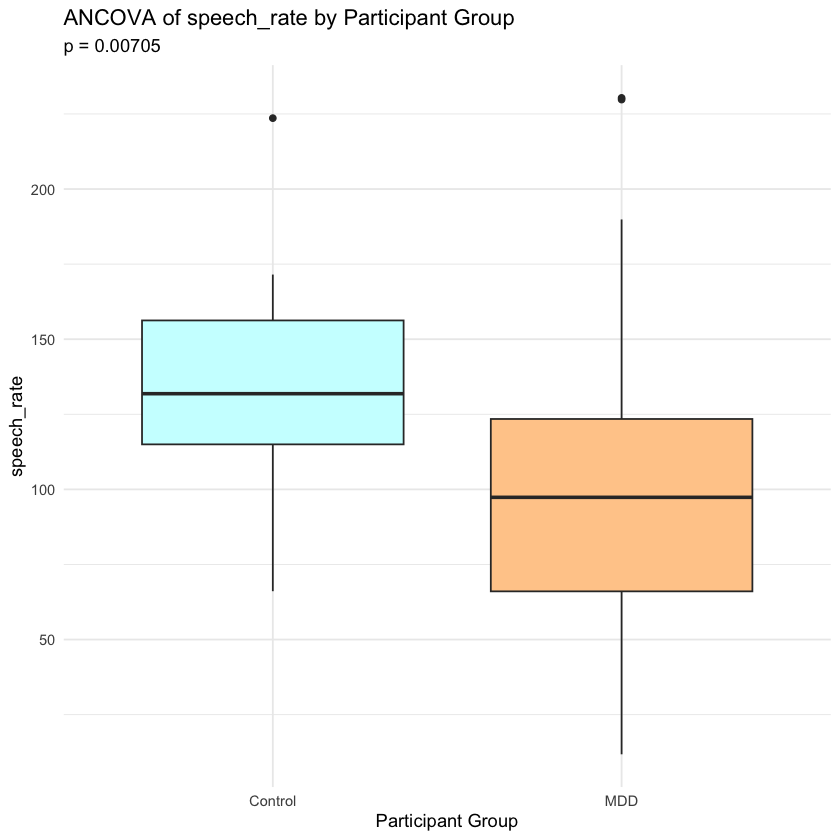

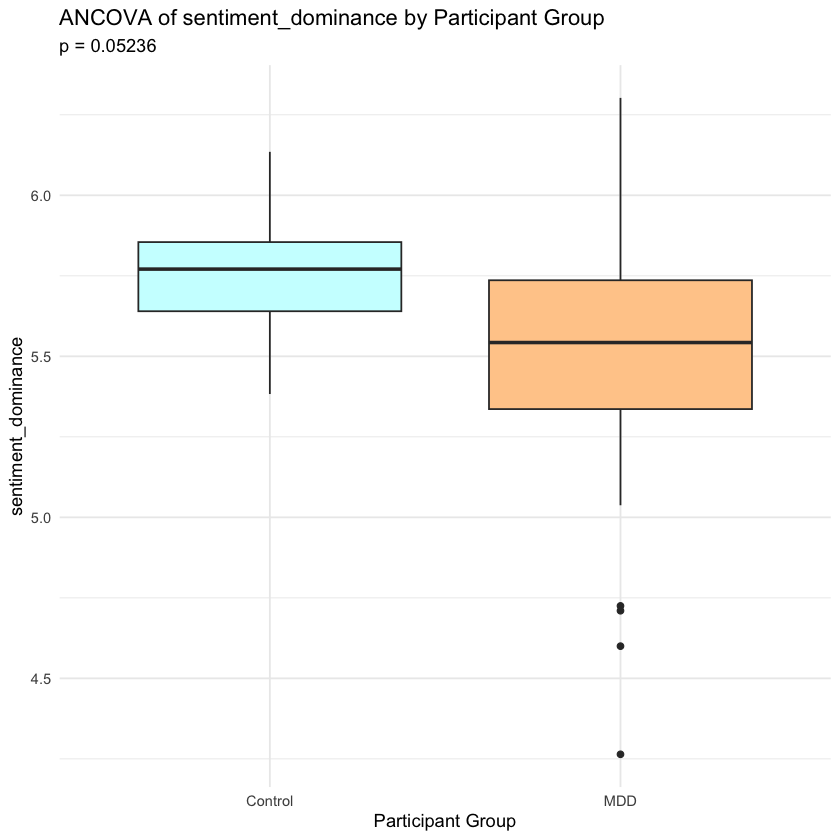

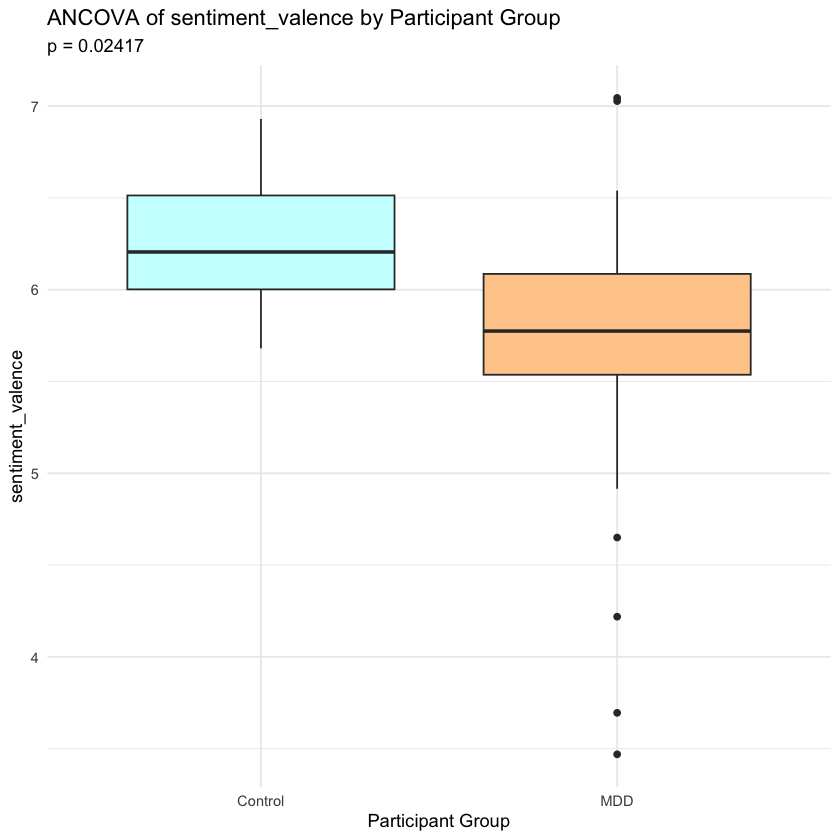

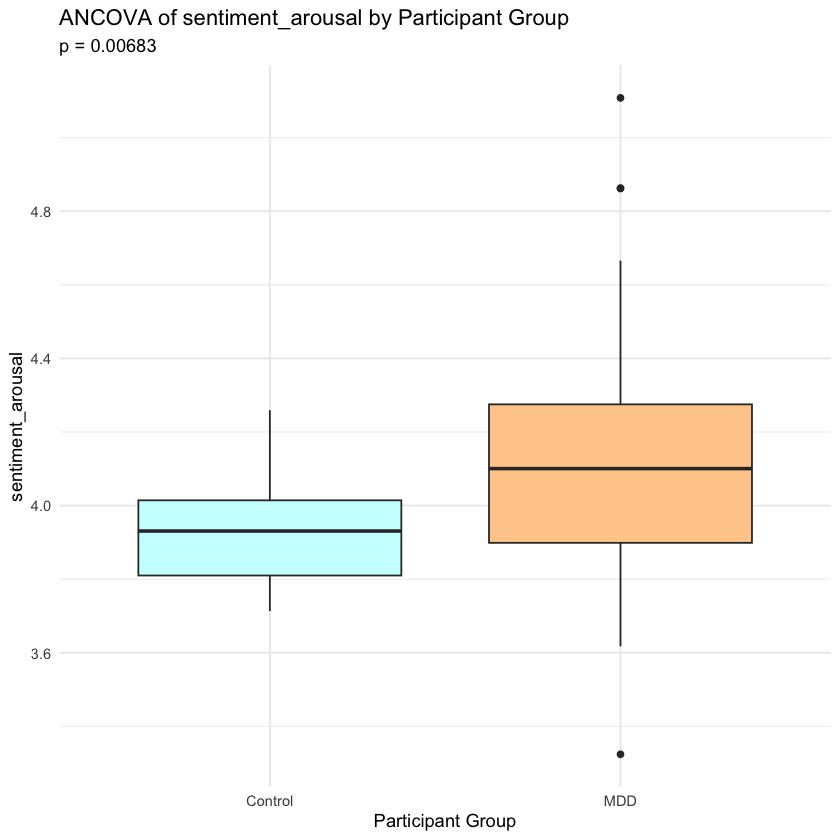

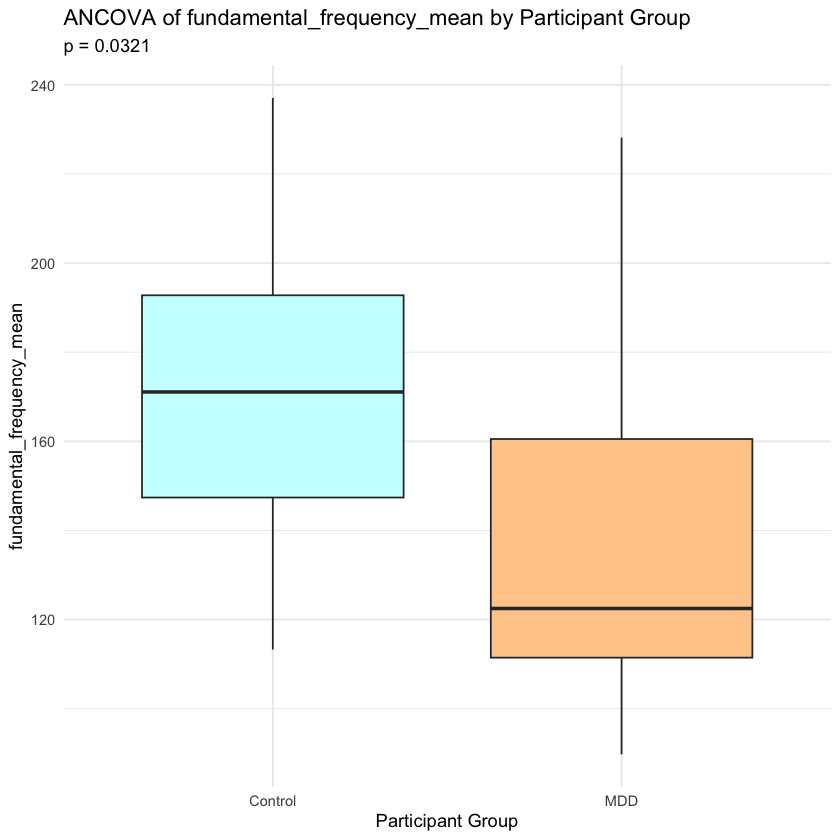

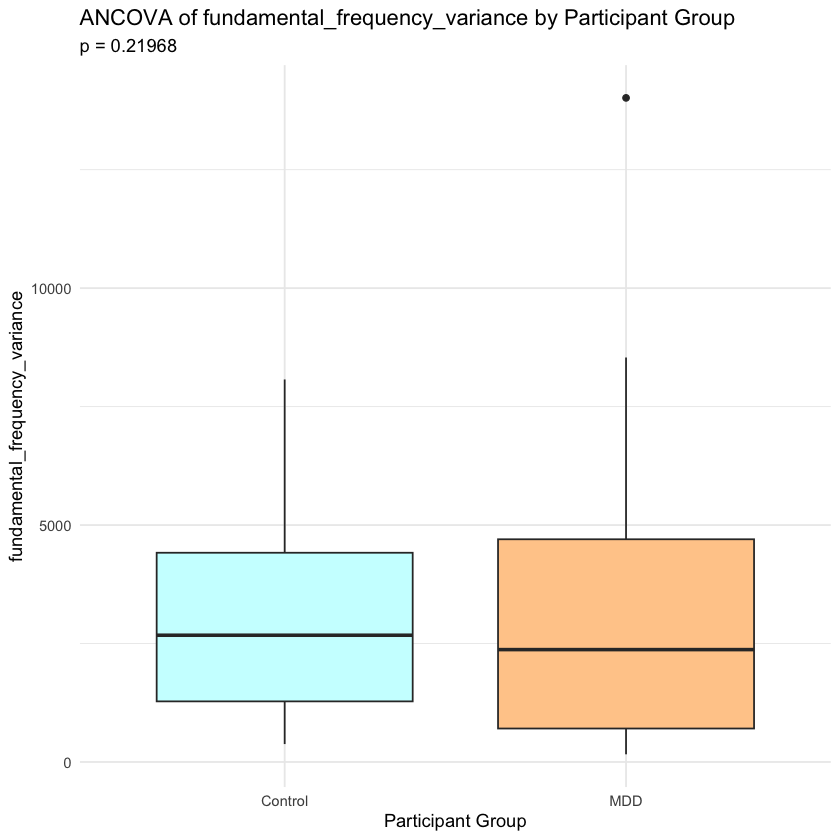

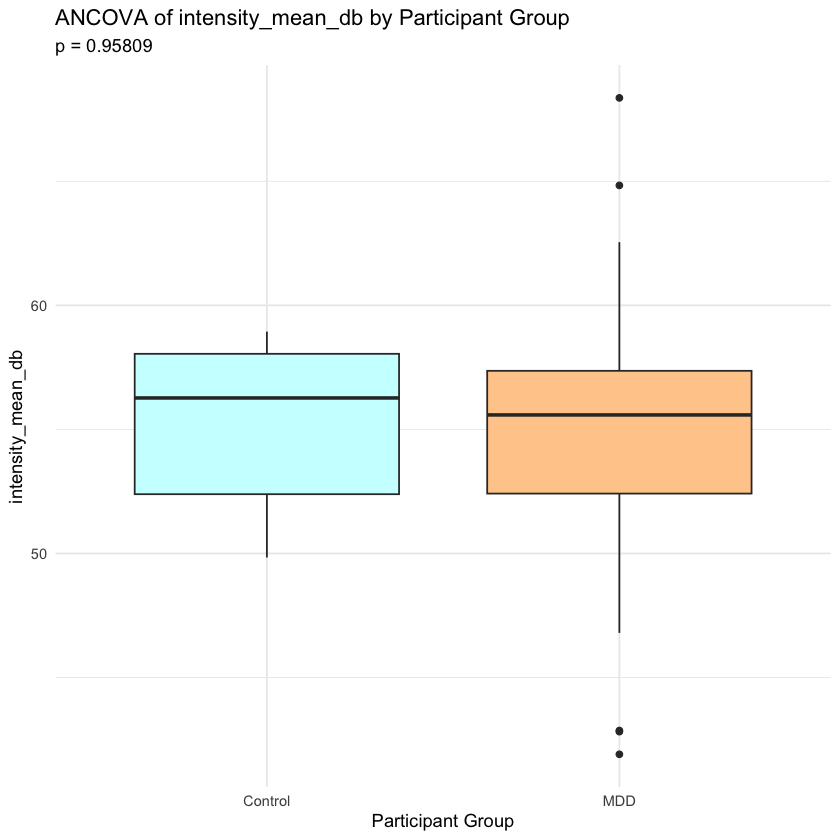

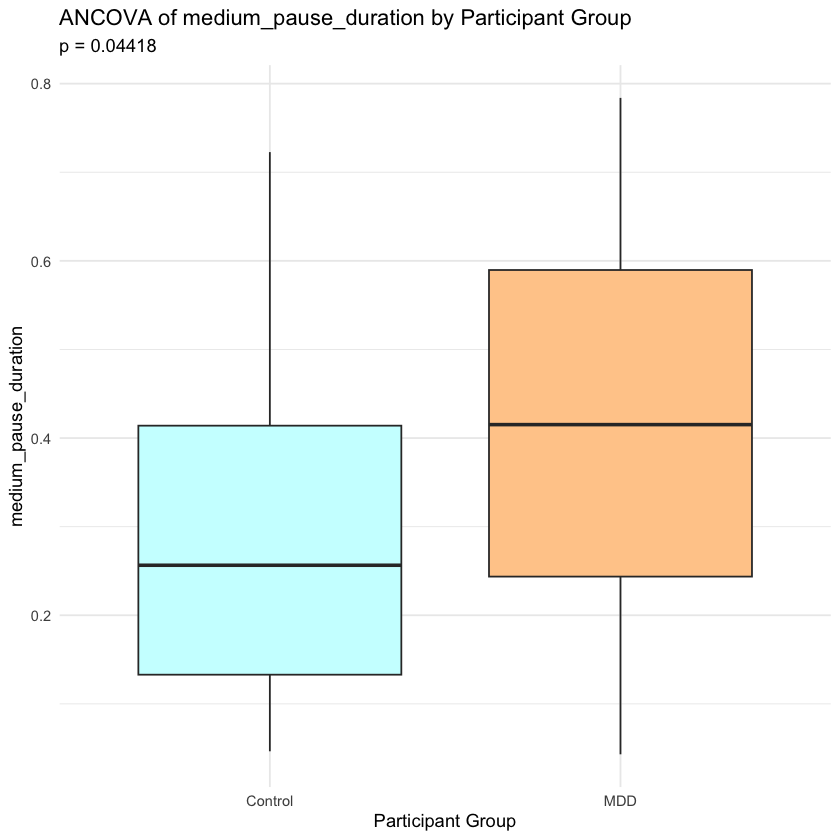

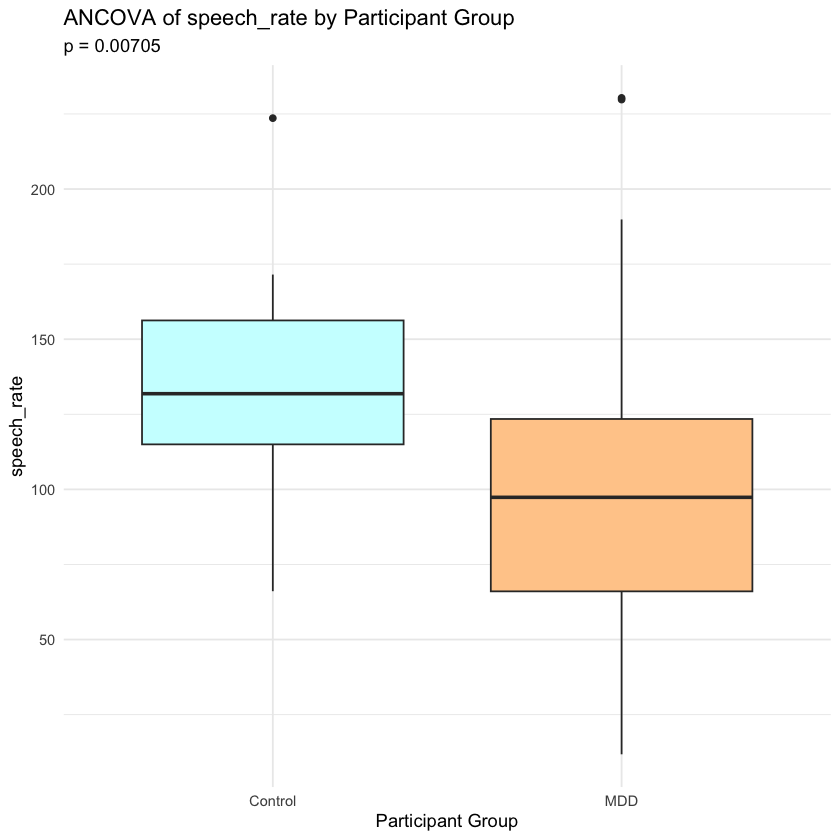

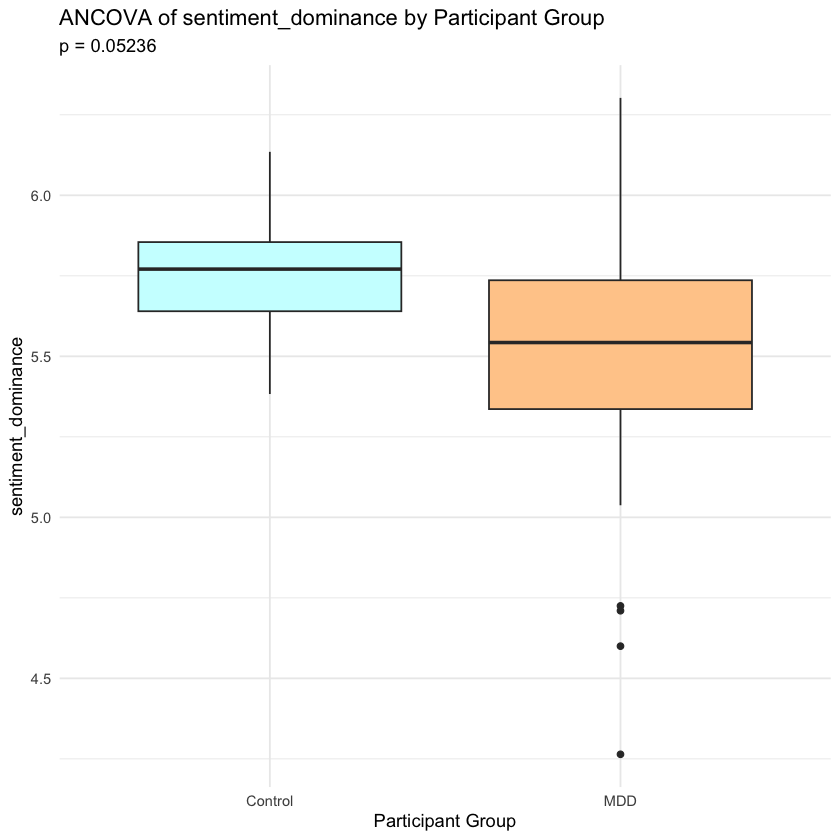

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


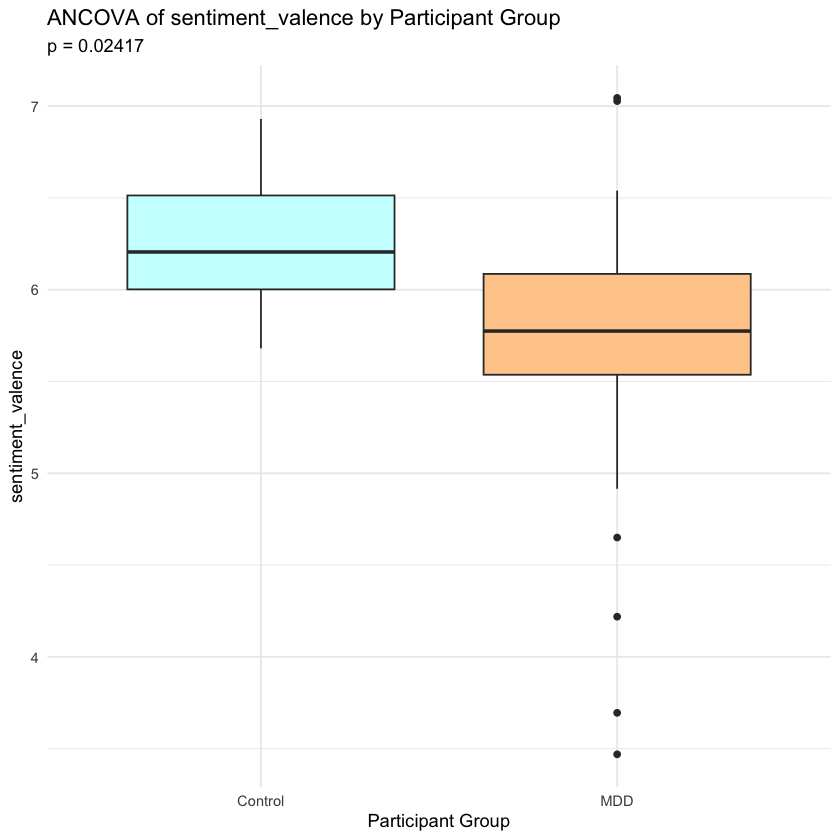

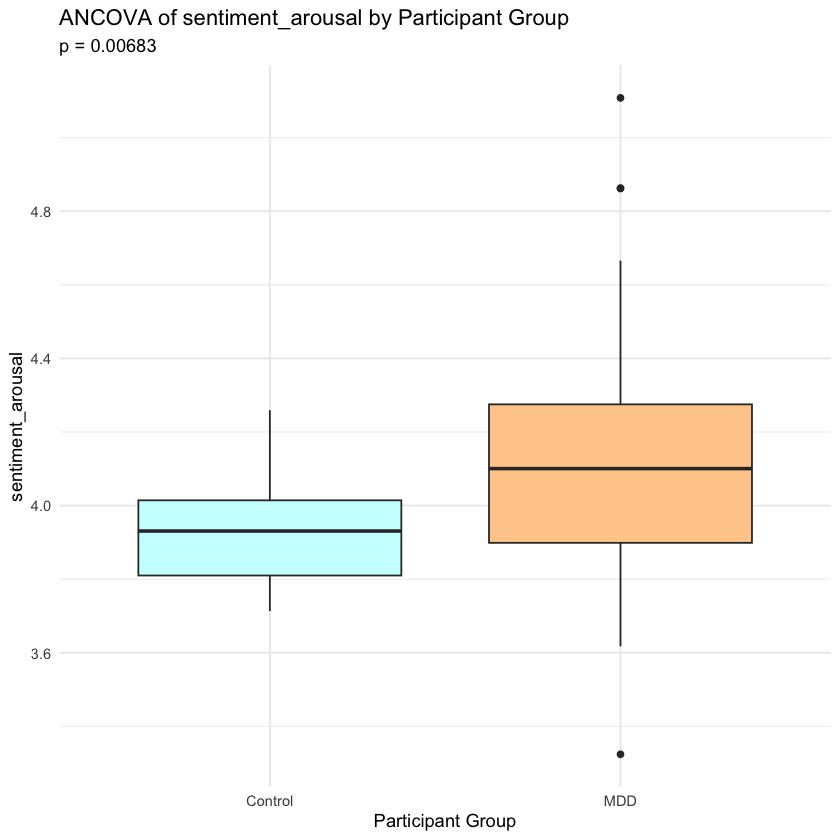

In [99]:
library(ggplot2)
library(dplyr)
library(car)

covariates <- c("sex", "age_learned_english", "age_screening")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[2]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[6]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))
    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#FFCC99")) +
            theme(legend.position = "none")
    
    plots[[plot_name]] <- plot
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


In [78]:
 ancova$'Sum Sq'

[1] 72.80758321  0.67019888  0.30292930  0.12634828  0.01449044  4.75654691

                        Variable    F_Value        Pr_F  Df
1     fundamental_frequency_mean  5.8228739 0.018647920 1/1
2 fundamental_frequency_variance  1.4061901 0.240006728 1/1
3              intensity_mean_db  0.2337733 0.630364772 1/1
4          medium_pause_duration  9.3562285 0.003226075 1/1
5                    speech_rate  8.1110797 0.005883866 1/1
6            sentiment_dominance  3.0428742 0.085819205 1/1
7              sentiment_valence  3.8846213 0.052991114 1/1
8              sentiment_arousal 11.6403172 0.001114531 1/1
[1] 0.018647920 0.240006728 0.630364772 0.003226075 0.005883866 0.085819205
[7] 0.052991114 0.001114531
$fundamental_frequency_mean
Anova Table (Type III tests)

Response: fundamental_frequency_mean
                    Sum Sq Df  F value    Pr(>F)    
(Intercept)         230945  1 311.4514 < 2.2e-16 ***
participant_group     4318  1   5.8229   0.01865 *  
sex                  33161  1  44.7213 6.165e-09 ***
age_learned_english     33  1   0.0441   0.83424 

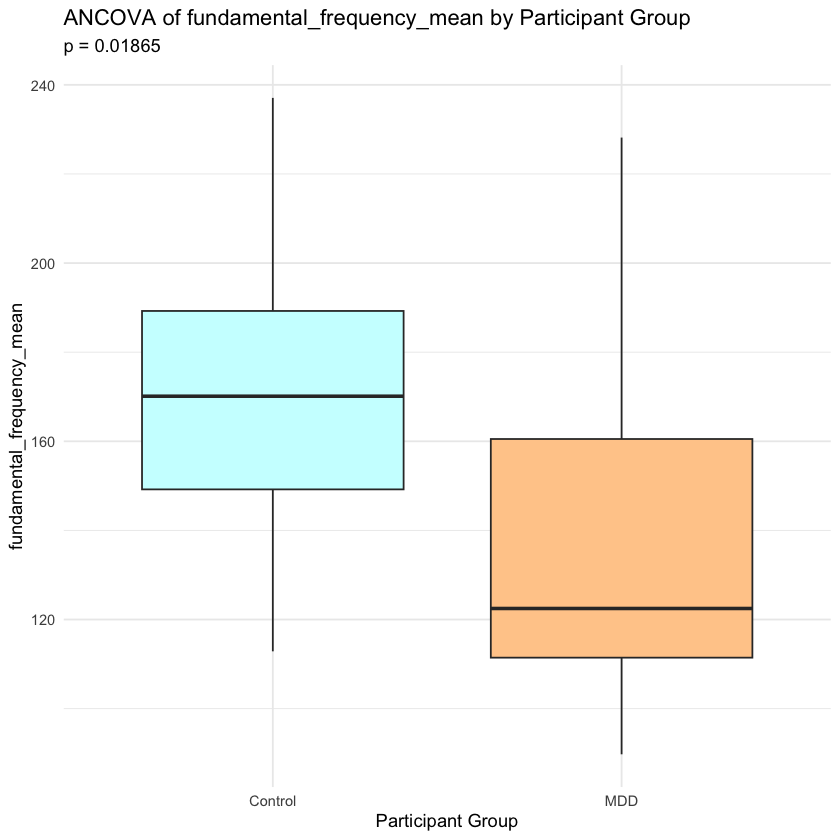

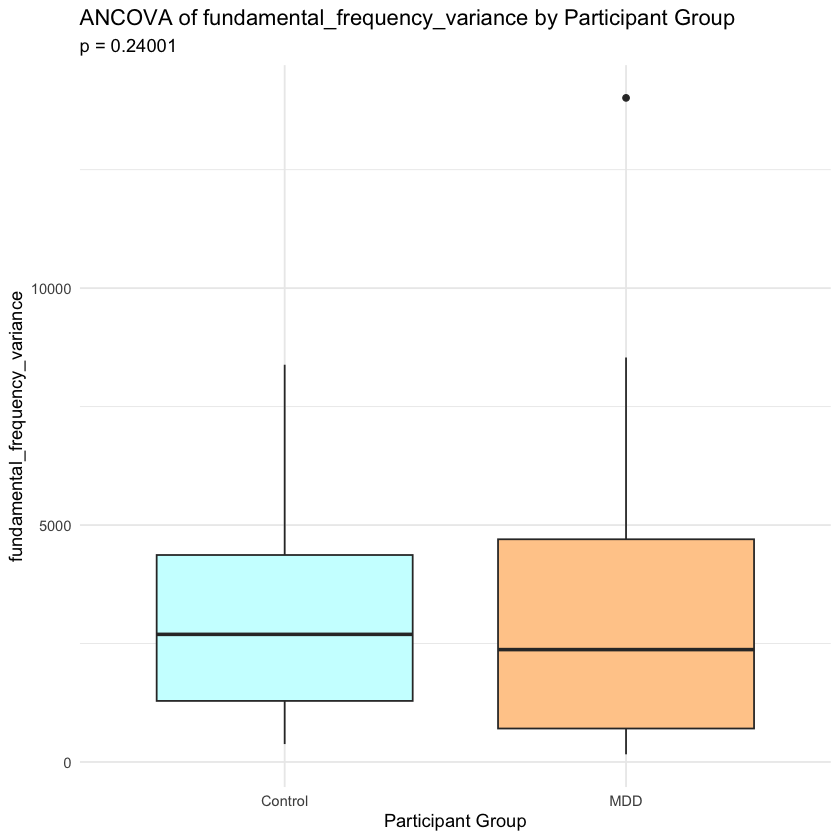

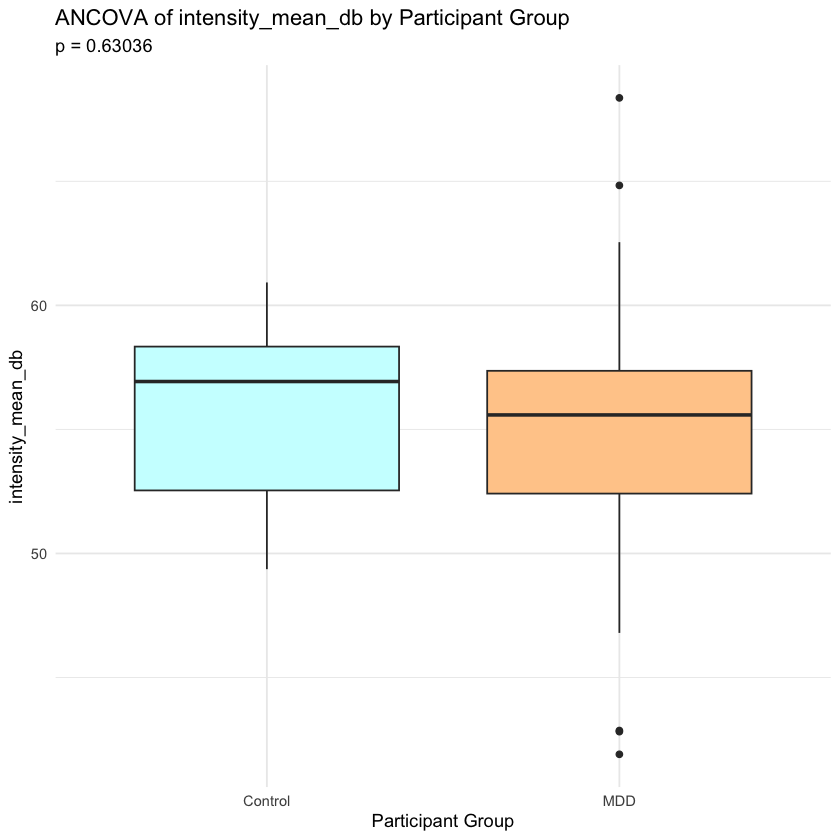

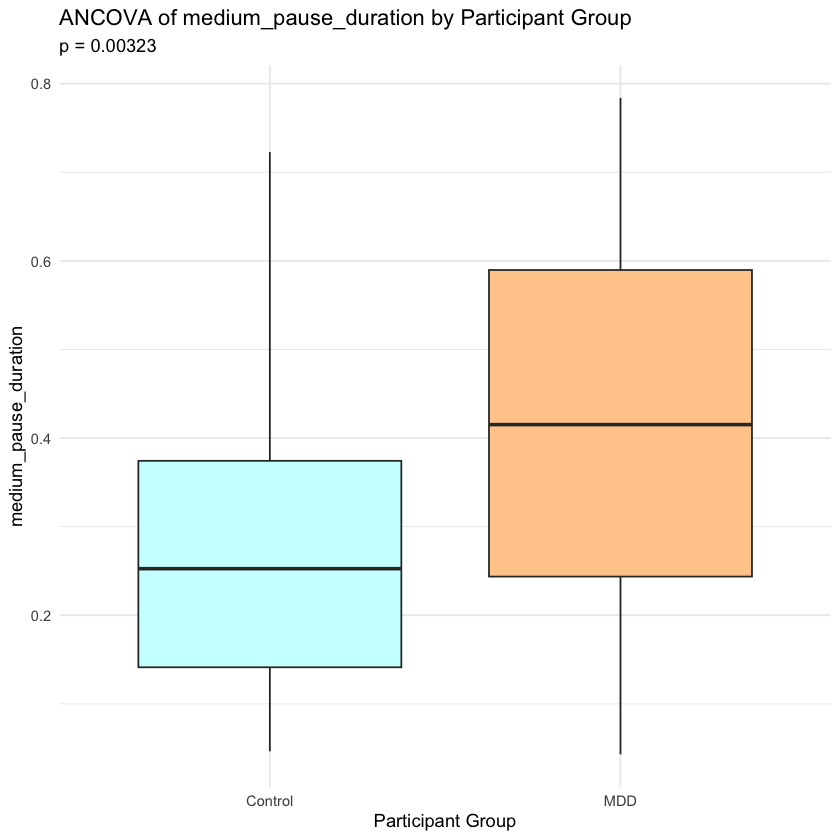

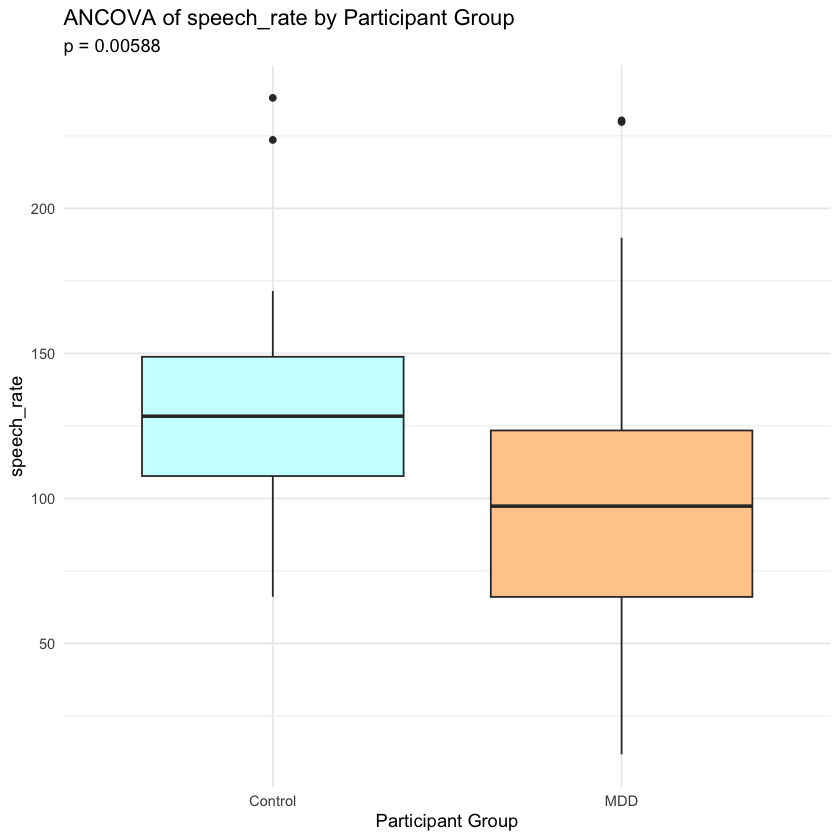

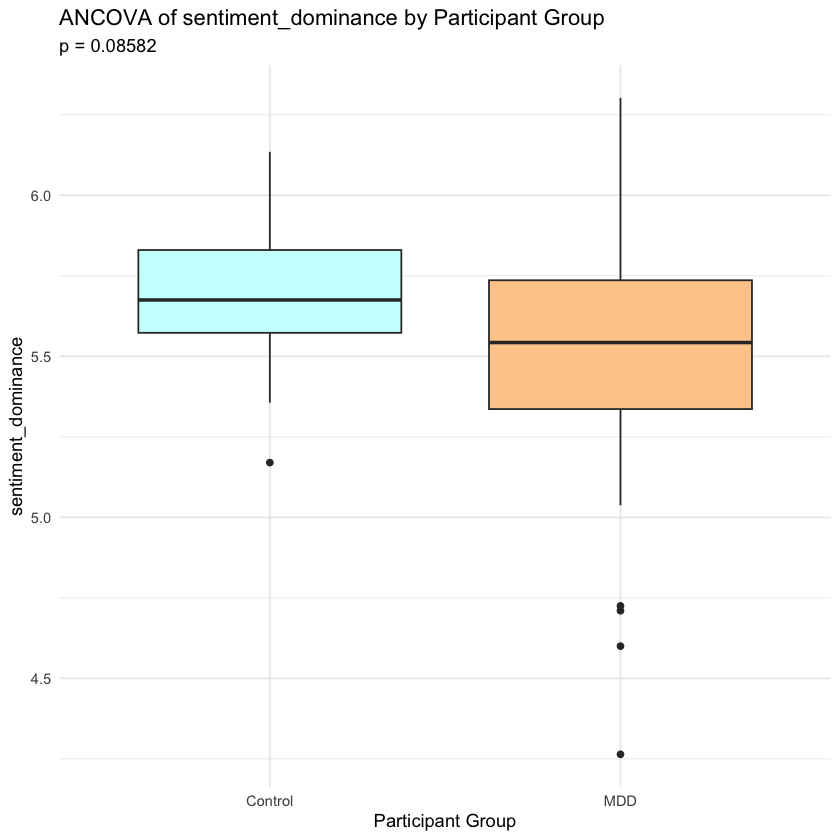

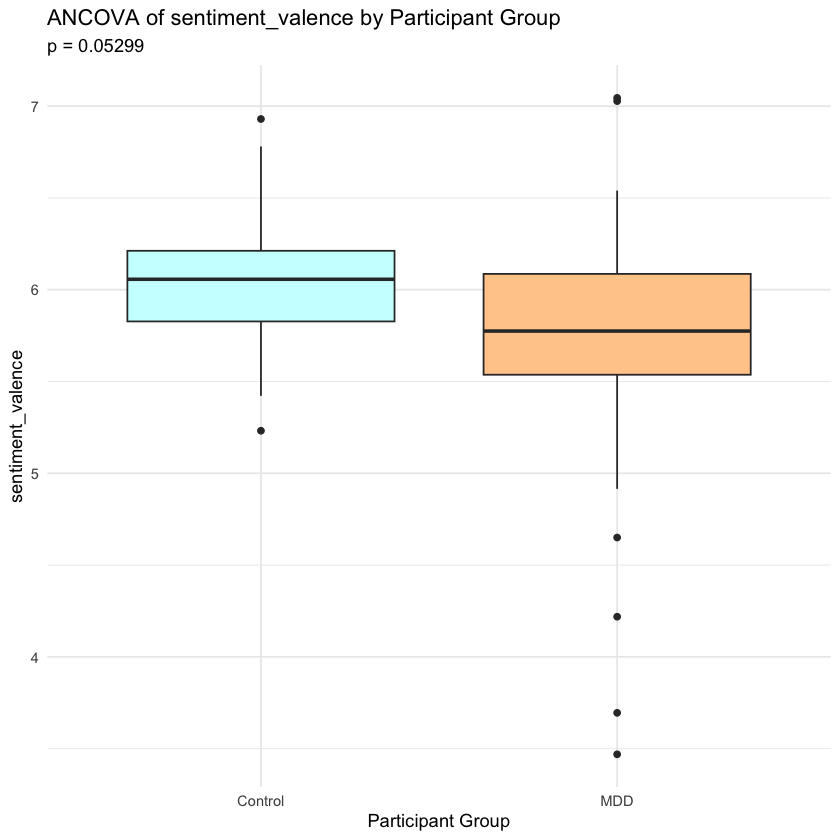

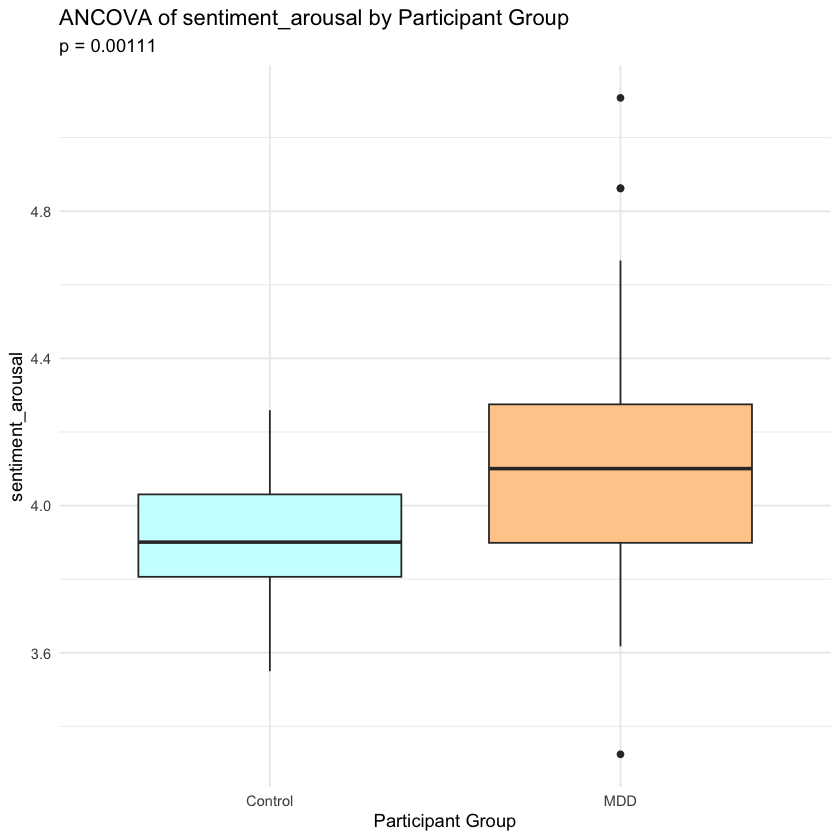

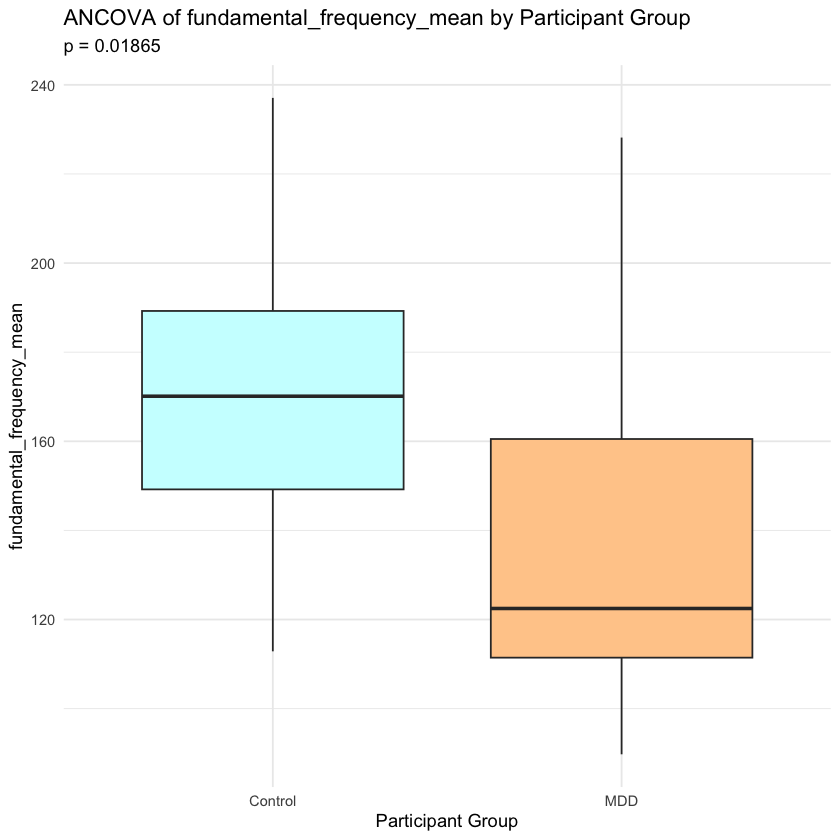

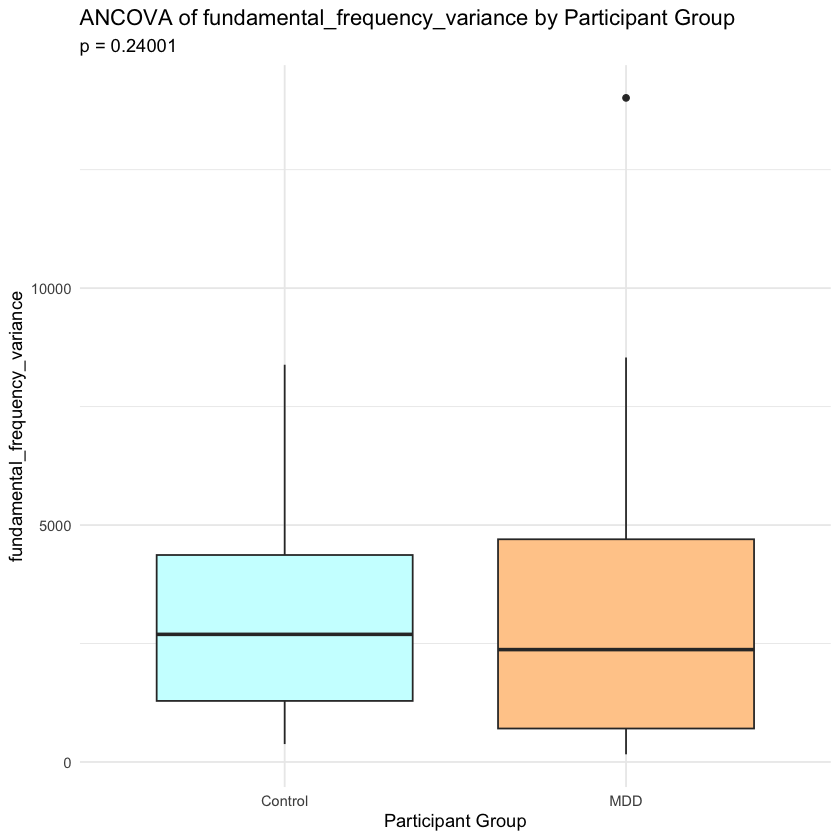

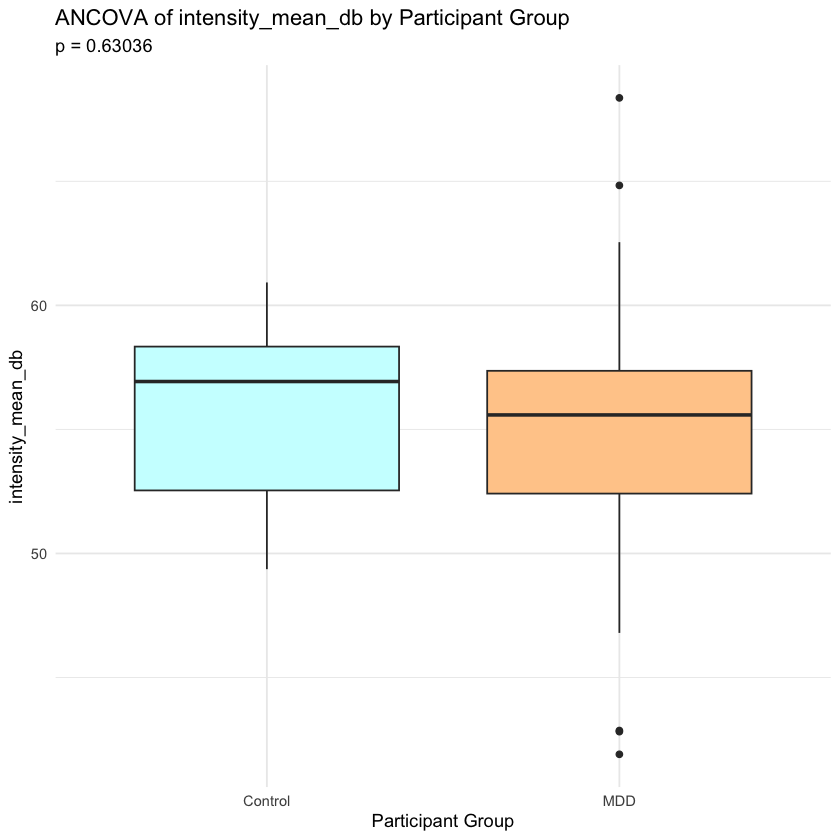

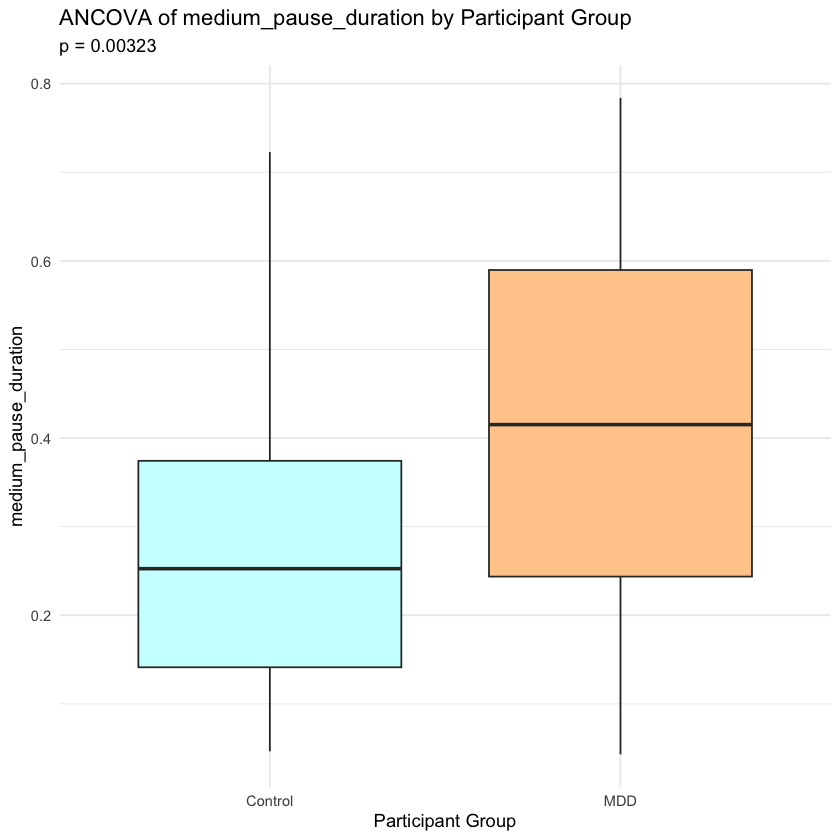

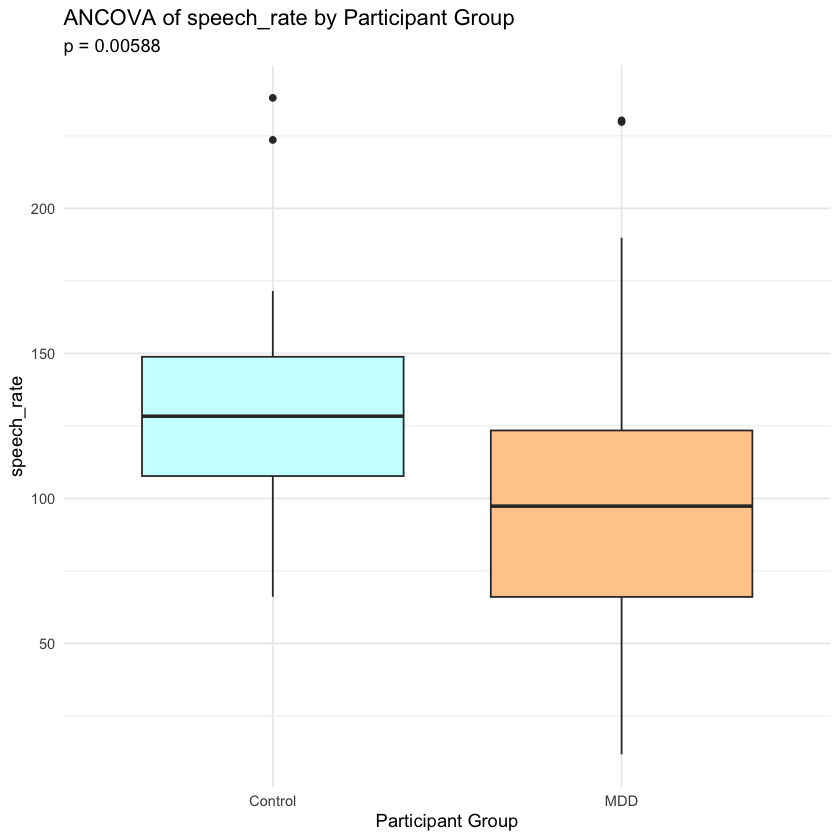

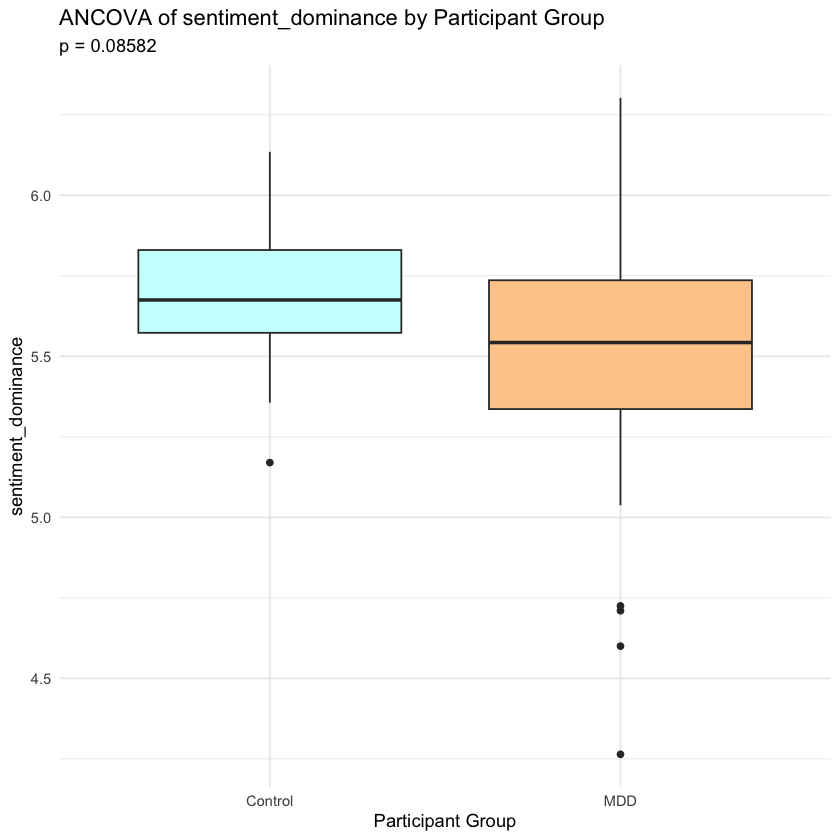

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


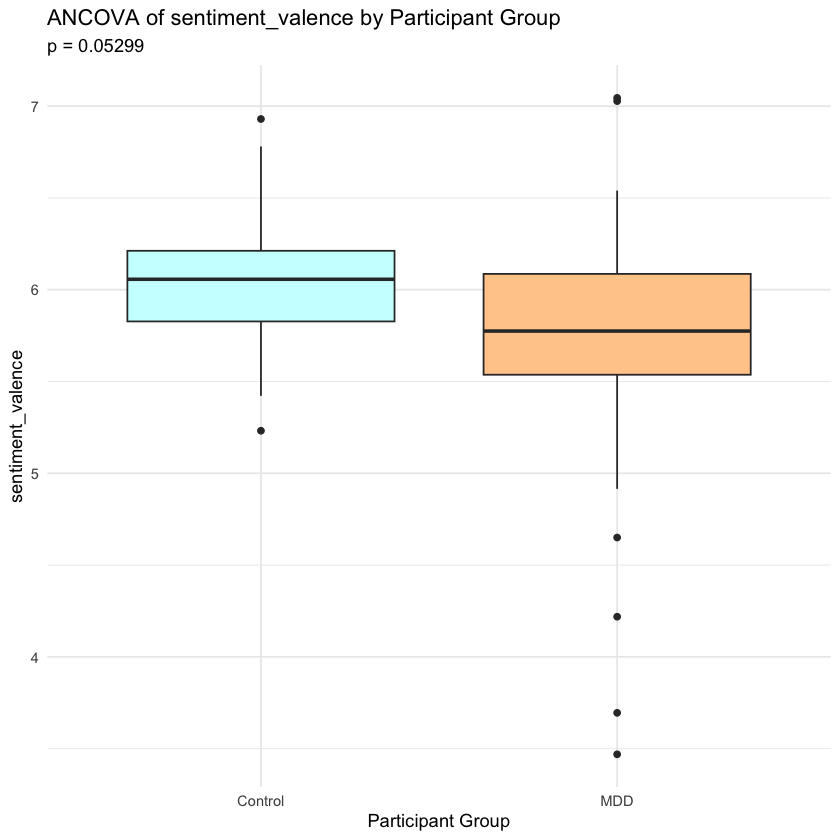

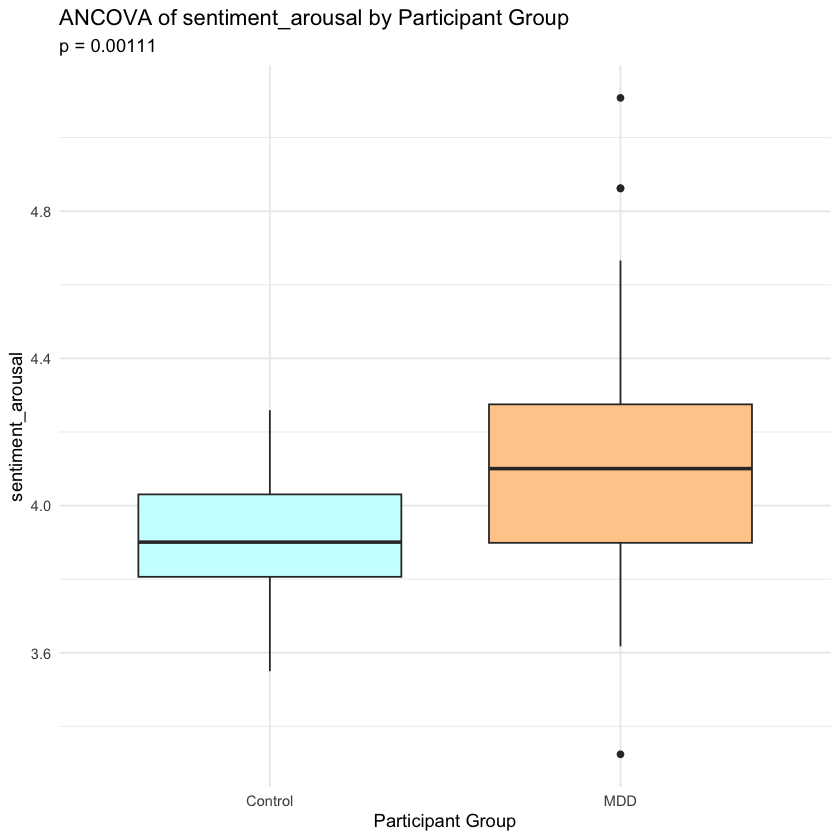

In [47]:
library(ggplot2)
library(dplyr)
library(car)

covariates <- c("sex", "age_learned_english", "age_screening")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Initialize a dataframe for storing ANCOVA statistics
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              stringsAsFactors = FALSE)
p_values_ancovas <- c() 

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")


# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    # Assuming 'participant_group' is the second term in the model
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[2]
    
    # Append p-value to the vector
    p_values_ancovas <- c(p_values_ancovas, p_value)
    
    # Append ANCOVA stats to the dataframe
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, F_Value = f_value, Pr_F = p_value, Df = paste(df1, df2, sep = "/")))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))
    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#FFCC99")) +
            theme(legend.position = "none")
    
    plots[[plot_name]] <- plot
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)


# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)



Correction for multiple comparisons

In [90]:
p_values_ancovas <- ancova_stats_df$Pr_F
adjusted_p_values <- p.adjust(p_values_ancovas, method = "BH")
# Display the original and adjusted p-values
data.frame(Original_P_Value = p_values_ancovas, Adjusted_P_Value = adjusted_p_values)

Original_P_Value,Adjusted_P_Value
<dbl>,<dbl>
0.032103815,0.06420763
0.219678147,0.25106074
0.958086812,0.95808681
0.044183824,0.06981219
0.007054921,0.02821968
0.052359142,0.06981219
0.024173300,0.06420763
0.006830906,0.02821968


ANCOVAS with interaction term

$fundamental_frequency_mean
Anova Table (Type III tests)

Response: fundamental_frequency_mean
                      Sum Sq Df  F value    Pr(>F)    
(Intercept)           215358  1 286.2309 < 2.2e-16 ***
participant_group       2722  1   3.6173  0.061685 .  
sex                     7978  1  10.6041  0.001806 ** 
age_learned_english       24  1   0.0318  0.859045    
age_screening            568  1   0.7556  0.387961    
participant_group:sex     45  1   0.0601  0.807091    
Residuals              48153 64                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

$fundamental_frequency_range
Anova Table (Type III tests)

Response: fundamental_frequency_range
                       Sum Sq Df F value    Pr(>F)    
(Intercept)            964810  1 38.7363 4.181e-08 ***
participant_group       79287  1  3.1833   0.07913 .  
sex                     14760  1  0.5926   0.44424    
age_learned_english     10565  1  0.4242   0.51720    
age_screening            

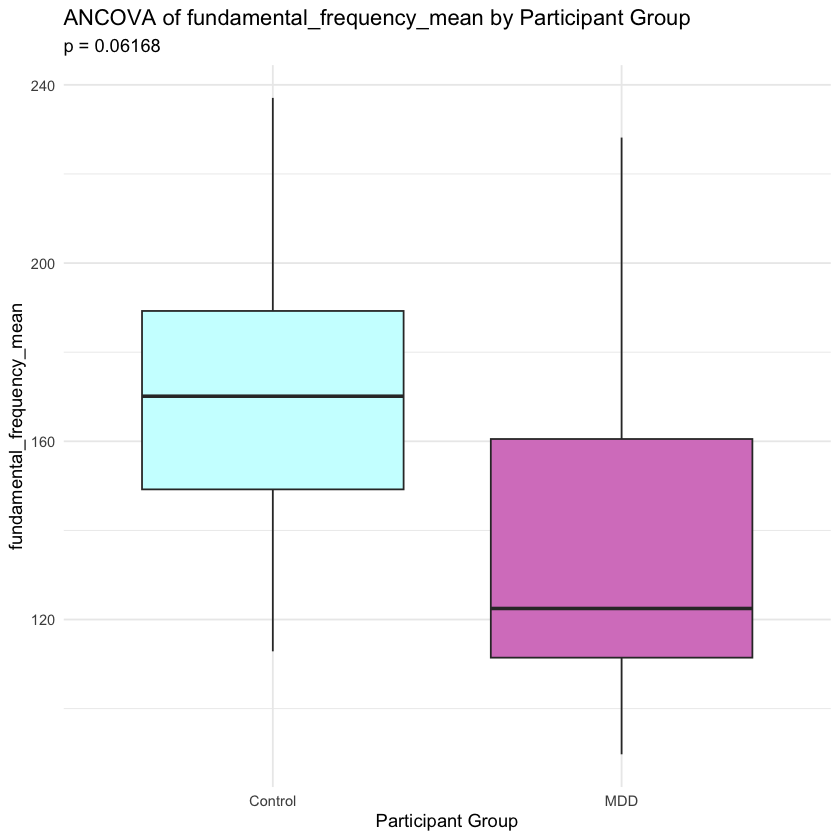


$fundamental_frequency_variance_ANCOVA_plot


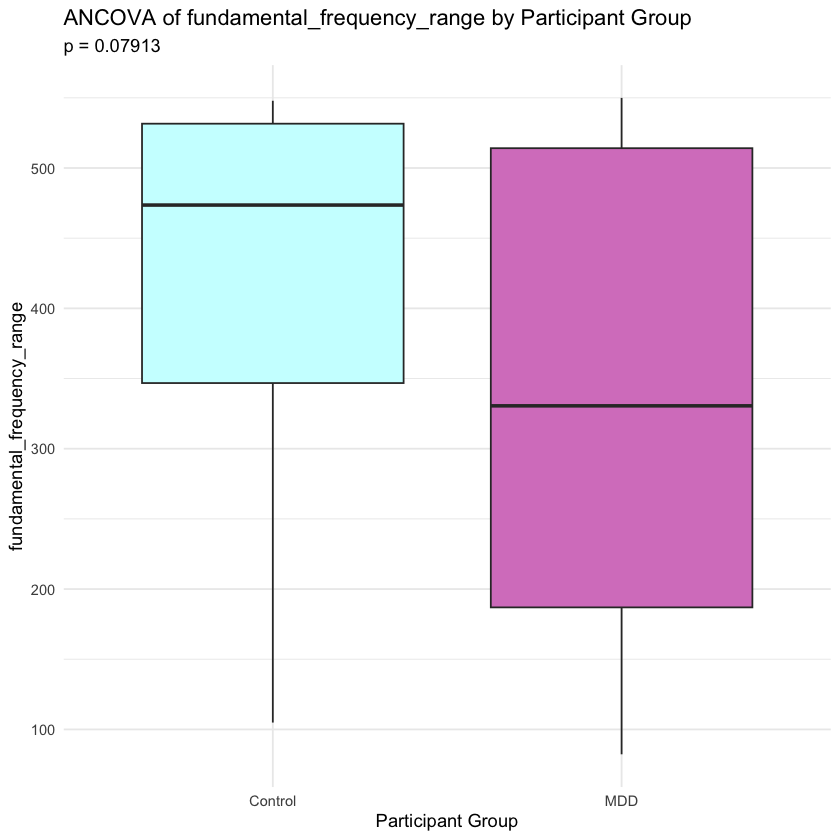


$intensity_mean_db_ANCOVA_plot


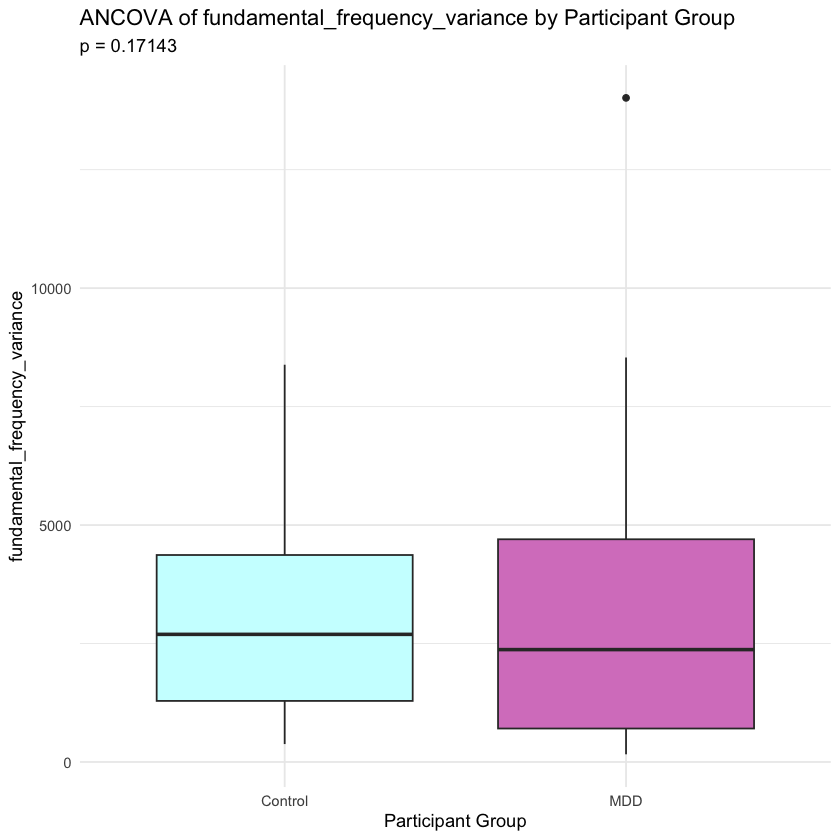


$intensity_range_ANCOVA_plot


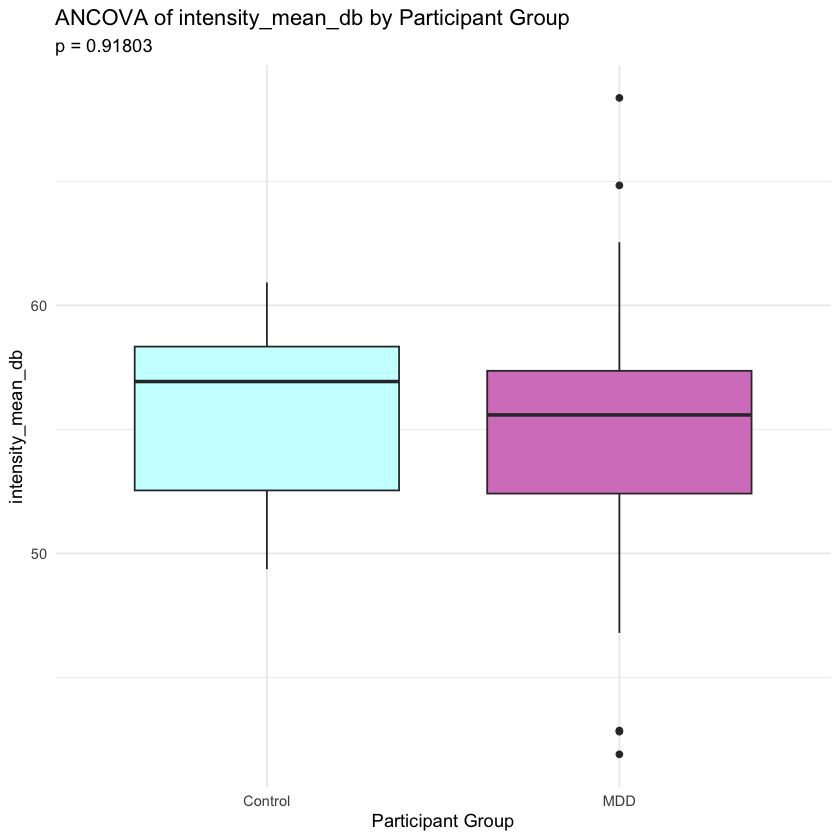


$long_pause_count_normalized_ANCOVA_plot


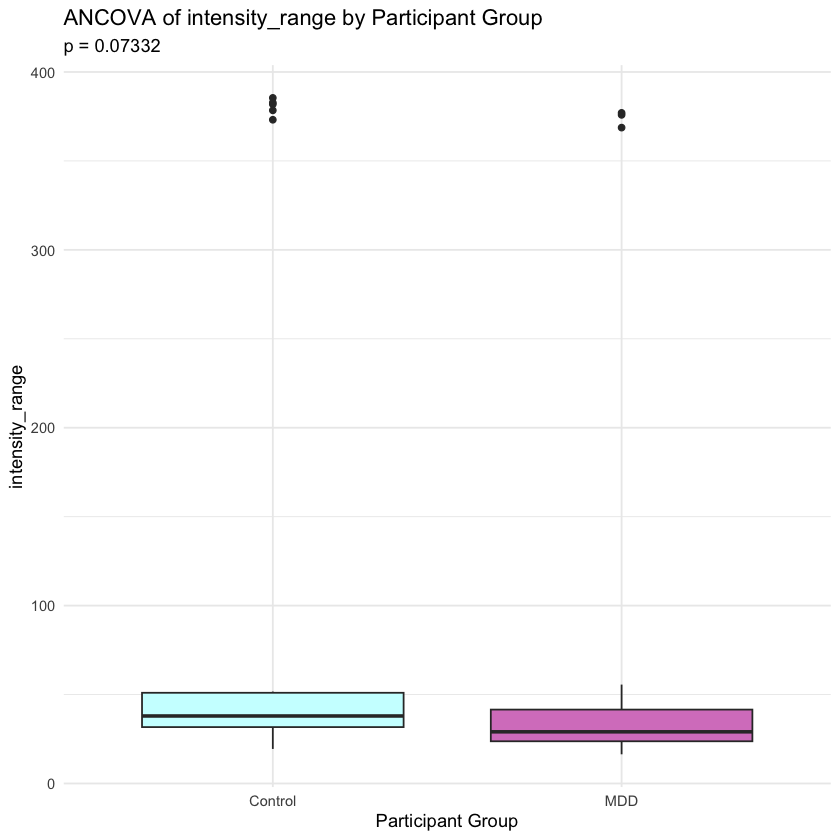


$long_pause_duration_ANCOVA_plot


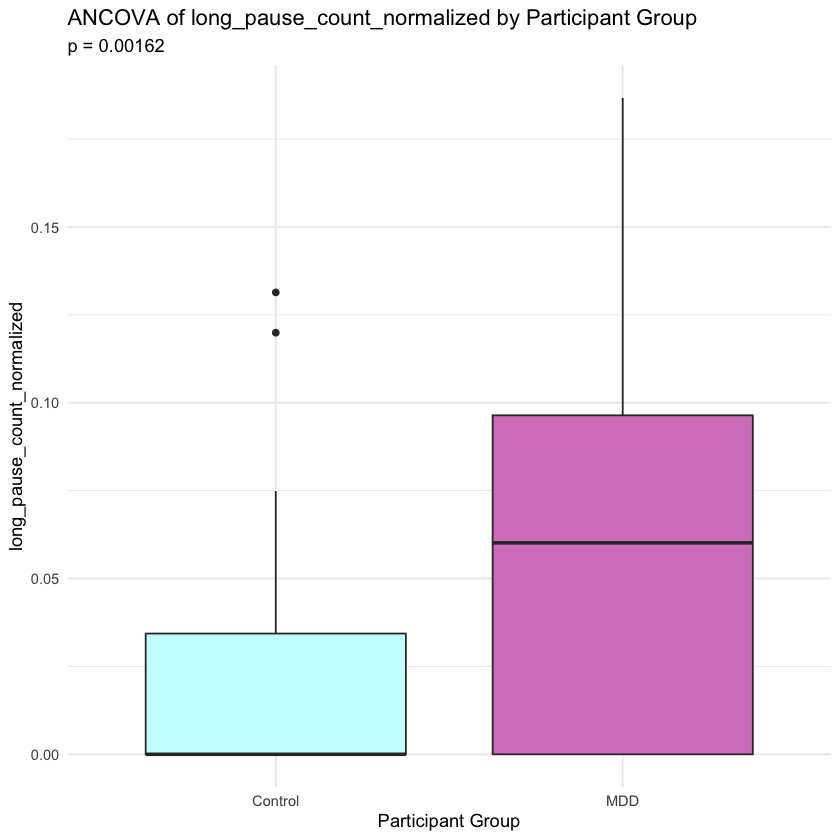


$medium_pause_count_normalized_ANCOVA_plot


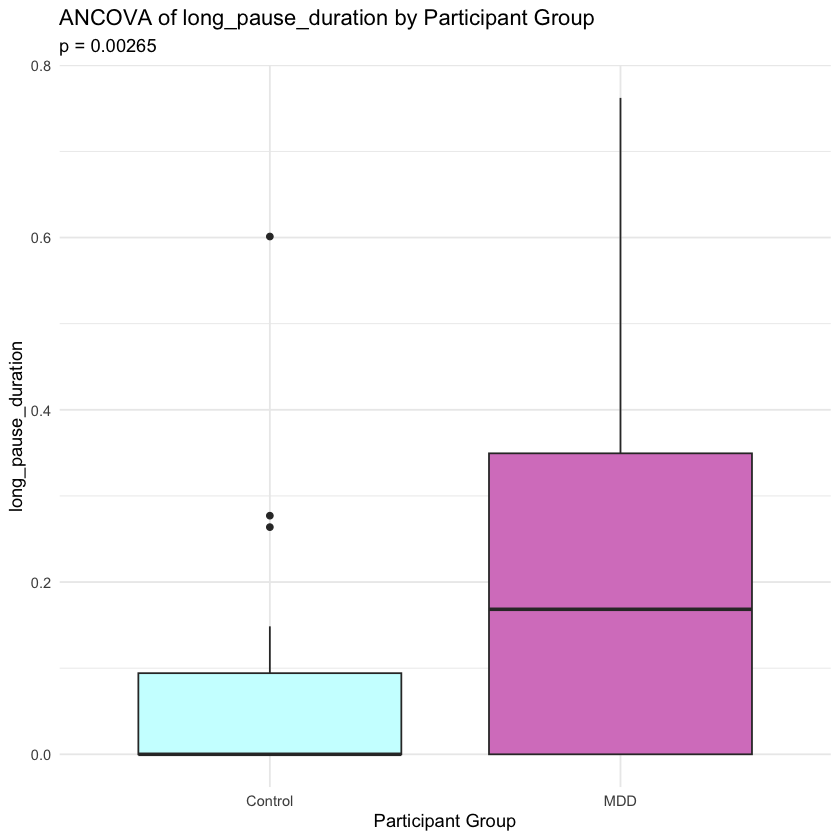


$medium_pause_duration_ANCOVA_plot


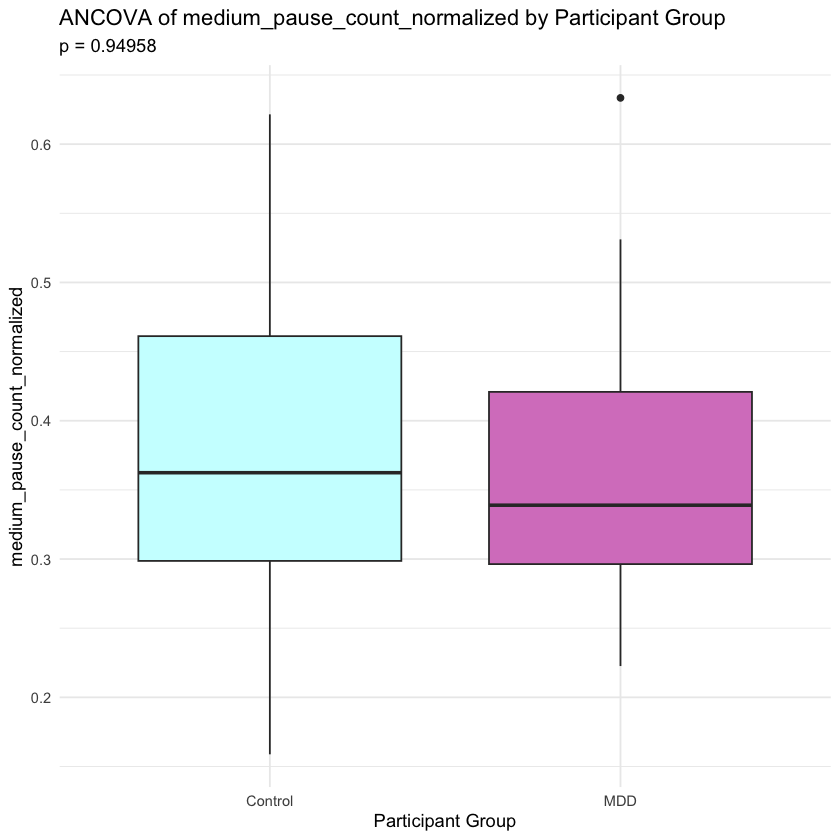


$speech_rate_ANCOVA_plot


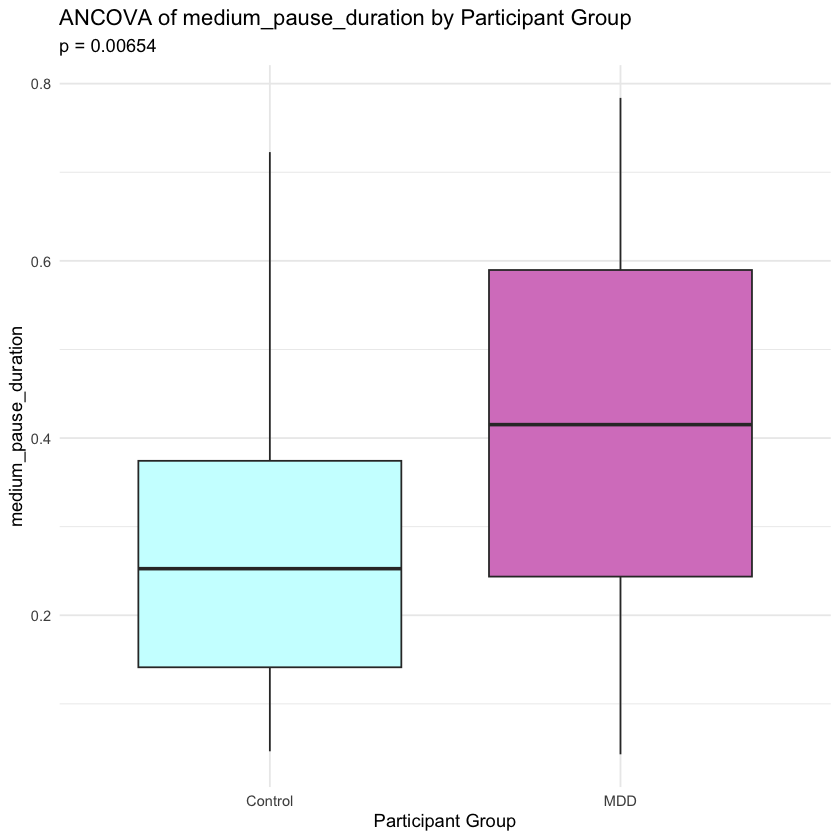


$sentiment_dominance_ANCOVA_plot


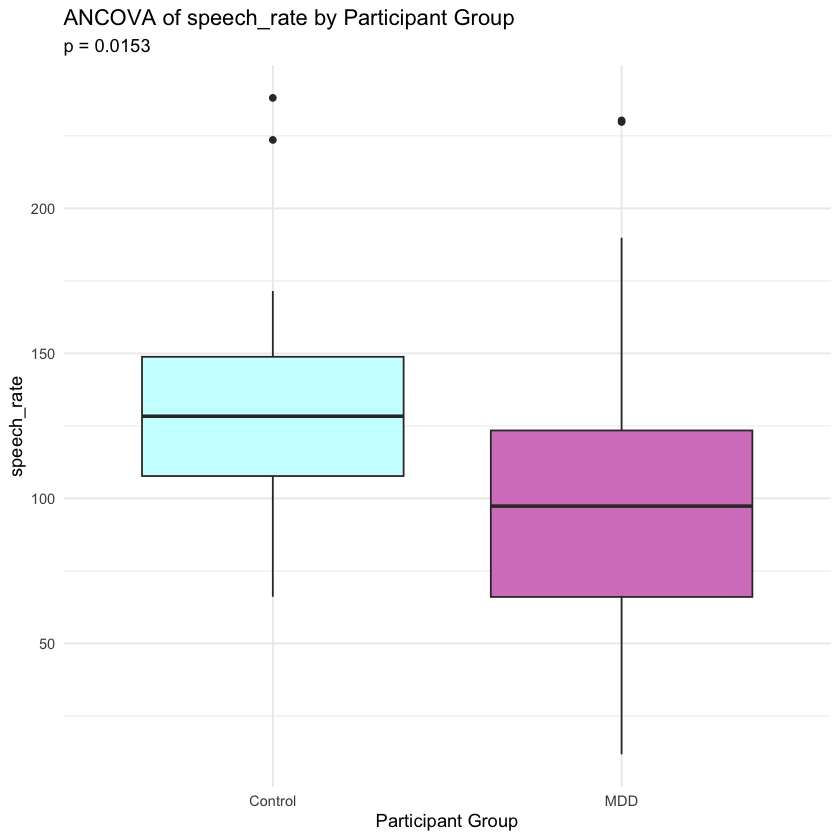


$sentiment_valence_ANCOVA_plot


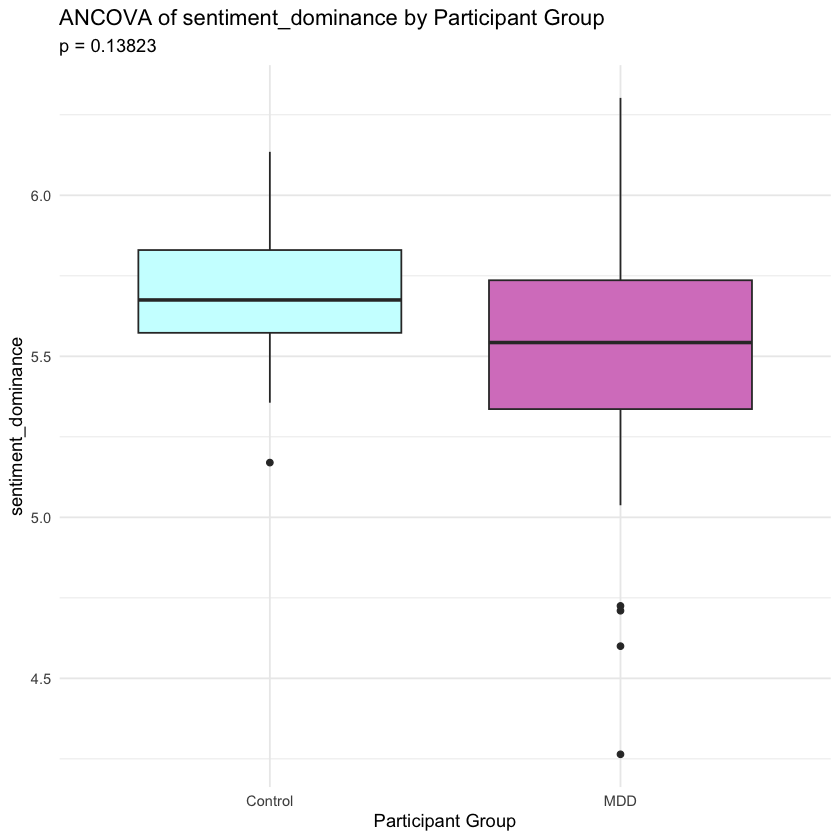


$sentiment_arousal_ANCOVA_plot


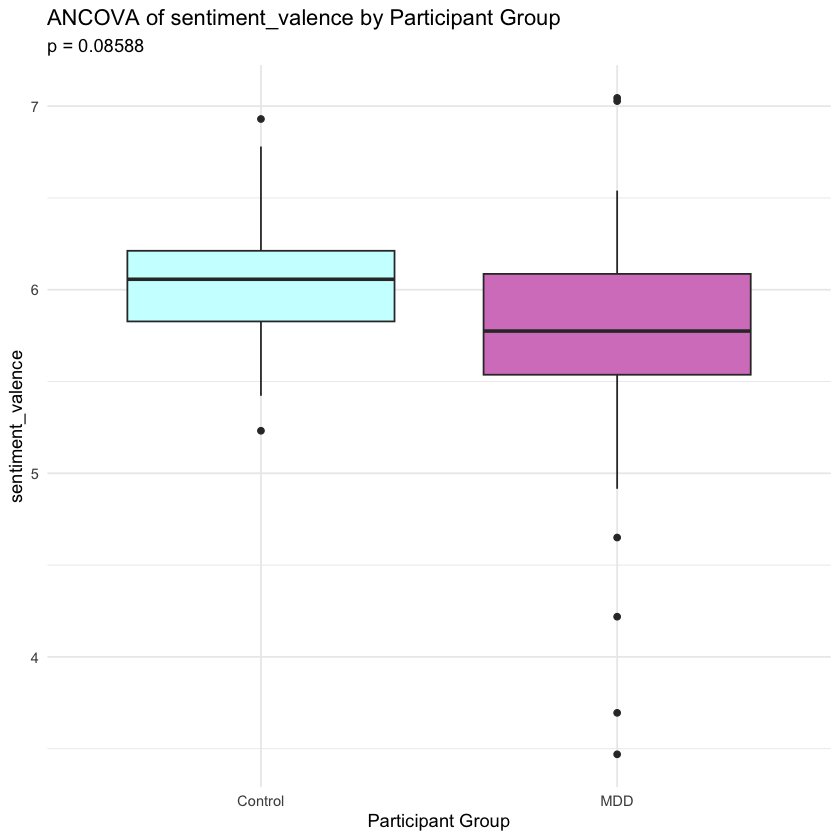

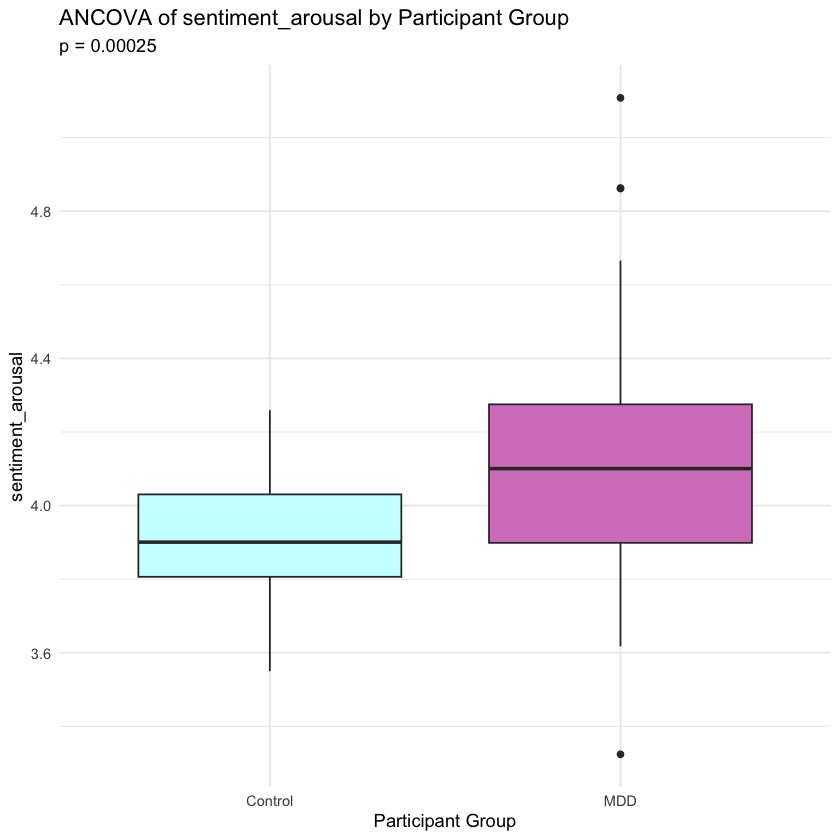

In [24]:
covariates <- c("age_learned_english", "age_screening")  # Removed 'sex' as it will be used in the interaction term
plots <- list()
results_ancova <- list()

WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

for (s in speech_variables) {
    # Filter out data without an assigned participant group
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]

    # Fit the linear model on the filtered data with interaction term
    formula <- as.formula(paste(s, "~ participant_group * sex +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)

    # Perform ANCOVA
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova

    # Extract p-value for participant_group effect
    p_value <- ancova$`Pr(>F)`[2]  # Assuming participant_group is the second term in the model

    # Formatting p-value for the plot
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    # Plotting
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#D783C6")) +
            theme(legend.position = "none")

    # Save the plot
    plots[[plot_name]] <- plot
}

# Print results and display plots
print(results_ancova)
print(plots)


Sample size

In [100]:
library(dplyr)

# Calculate mean and SD of age for each participant group
age_stats <- WL_jou_bl_feeling %>%
  group_by(participant_group) %>%
  summarise(
    mean_age = mean(age_screening, na.rm = TRUE),
    sd_age = sd(age_screening, na.rm = TRUE)
  )

# Calculate percentage of M and F in each participant group
sex_distribution <- WL_jou_bl_feeling %>%
  group_by(participant_group, sex) %>%
  summarise(
    count = n(),
    .groups = 'drop'
  ) %>%
  mutate(
    percentage = count / sum(count) * 100
  )

# Adjusting previous code for unique IDs and NA participants
# Count unique IDs for each combination of sex and participant group
unique_counts <- WL_jou_bl_feeling %>%
  group_by(participant_group, sex) %>%
  summarise(unique_ids = n_distinct(participant_external_id), .groups = 'drop')

# Filter rows where both sex and participant_group are NA
na_participants <- WL_jou_bl_feeling %>%
  filter(is.na(sex) | is.na(participant_group)) %>%
  distinct(participant_external_id)

# Print the results
print(age_stats)
print(sex_distribution)
print(unique_counts)
print(na_participants)


# A tibble: 2 x 3
  participant_group mean_age sd_age
  <fct>                <dbl>  <dbl>
1 Control               46.6   19.5
2 MDD                   44.0   14.3
# A tibble: 4 x 4
  participant_group sex   count percentage
  <fct>             <chr> <int>      <dbl>
1 Control           F        13      19.7 
2 Control           M         3       4.55
3 MDD               F        22      33.3 
4 MDD               M        28      42.4 
# A tibble: 4 x 3
  participant_group sex   unique_ids
  <fct>             <chr>      <int>
1 Control           F             13
2 Control           M              3
3 MDD               F             22
4 MDD               M             28
# A tibble: 0 x 1
# i 1 variable: participant_external_id <chr>


In [101]:
mean(WL_jou_bl_feeling$hamd17_total_pre, na.rm = TRUE)
sd(WL_jou_bl_feeling$hamd17_total_pre, na.rm = TRUE)


[1] 21.0625

[1] 4.091539

In [59]:
# Filter the dataframe for the MDD group and male sex
mdd_male_df <- WL_jou_bl_feeling %>% 
               filter(participant_group == "MDD", sex == "M")

# Calculate age statistics
age_range <- range(mdd_male_df$age_screening, na.rm = TRUE)
age_mean <- mean(mdd_male_df$age_screening, na.rm = TRUE)
age_median <- median(mdd_male_df$age_screening, na.rm = TRUE)

# Print the results
print(paste("Age range: ", age_range[1], "to", age_range[2]))
print(paste("Mean age: ", age_mean))
print(paste("Median age: ", age_median))

[1] "Age range:  24 to 75"
[1] "Mean age:  47.9642857142857"


[1] "Median age:  49.5"
